**TODO**:
- [X] BERT (and Longfromer) on the same test setused by conformal -> Longformer is better
- [X] Performance on documents without encoding problems -> The performance are the same
- [X] Use get_clean_text in TextDataset and finetune the model again
- [X] Test the model finetuned on clean text
- [X] Make a blacklist of inconsistent train and valid
- [X] Evaluate the existing model on consistent and inconsistent valid
- [X] Train just on consistent
- [ ] Maybe is lower because inconisistent have the same enconding problem, allowing it to "correctely" predict them

**FINDING**
- Using confromal prediction, when the model is sure (i.e., singleton) the MAE is very low.
- When there are multiple prediction, around 80% of the time it contains the correct one.
- Taking the argmax is still the better way compared to takining the one that surpass the most the threshold (even if relative to the size of the threshold).
- Apparently when training using the clean text, the model perform better when doining inference on the non clean text.
- The model trainind with not clean text (evaluated on not clean text) is better than the one that uses clean text.
- As hypotized, the MAE on consistent data in much lower (0.83) than the MAE on inconsistent (12.83)


# Data Preparation

In [3]:
import os
# cuda_visible_devices = 0,1,2,3
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

import pandas as pd

import numpy as np
from tabulate import tabulate
import seaborn as sns
from tqdm import tqdm

import nltk
from nltk import WordPunctTokenizer
from nltk import TreebankWordTokenizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords

import stanza
stanza.download('en')

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

import torch

RANDOM_SEED = 42

[nltk_data] Downloading package punkt to /home/alocaputo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alocaputo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/data01/alocaputo/miniconda3/envs/icdar2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-12 13:12:37 INFO: Downloaded file to /home/alocaputo/stanza_resources/resources.json
2025-03-12 13:12:37 INFO: Downloading default packages for language: en (Engl

In [4]:
texts_path = './data/Task2/texts'

train_path = os.path.join(texts_path, 'train')
valid_path = os.path.join(texts_path, 'valid')

train_files = os.listdir(train_path)
valid_files = os.listdir(valid_path)

f"Train: {len(train_files)}, Test: {len(valid_files)}"

label2century = {1: '17th century', 2: '18th century', 3: '19th century', 4: '20th century', 5: '21st century'}

train21 = pd.read_csv('./data/Task2/task2.1/train.csv')
valid21 = pd.read_csv('./data/Task2/task2.1/valid.csv')

train22 = pd.read_csv('./data/Task2/task2.2/train.csv')
valid22 = pd.read_csv('./data/Task2/task2.2/valid.csv')

train = pd.merge(train21, train22, on='id')
train.rename(columns={'label_x': 'century', 'label_y': 'decade'}, inplace=True)
train['file_name'] = train['id']
train['id'] = train.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train.set_index('id', inplace=True)

valid = pd.merge(valid21, valid22, on='id')
valid.rename(columns={'label_x': 'century', 'label_y': 'decade'}, inplace=True)
valid['file_name'] = valid['id']
valid['id'] = valid.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid.set_index('id', inplace=True)

In [1038]:
def decade2year(deca):
    return ((deca // 10) + 16) * 100 + ((deca % 10)) * 10

def year2cd(year):
    return ((year // 100 - 16) * 10  + (year - (year // 100)*100)//10)

### Check data consistency

In [1043]:
texts_path1 = './data/Task1/texts'

train_path1 = os.path.join(texts_path, 'train')
valid_path1 = os.path.join(texts_path, 'valid')

train_files1 = os.listdir(train_path1)
valid_files1 = os.listdir(valid_path1)

print(f"Train: {len(train_files1)}, Test: {len(valid_files1)}")

label2century = {1: '17th century', 2: '18th century', 3: '19th century', 4: '20th century', 5: '21st century'}

train11 = pd.read_csv('./data/Task1/task1.1/train.csv')
valid11 = pd.read_csv('./data/Task1/task1.1/valid.csv')

train12 = pd.read_csv('./data/Task1/task1.2/train.csv')
valid12 = pd.read_csv('./data/Task1/task1.2/valid.csv')

train1 = pd.merge(train11, train12, on='id')
train1.rename(columns={'label_x': 'epoch_label', 'label_y': 'subepoch_label'}, inplace=True)
train1['file_name'] = train1['id']
train1['id'] = train1.id.str.replace('train_text', '').str.replace('.txt', '').astype(int)
train1.set_index('id', inplace=True)

valid1 = pd.merge(valid11, valid12, on='id')
valid1.rename(columns={'label_x': 'epoch_label', 'label_y': 'subepoch_label'}, inplace=True)
valid1['file_name'] = valid1['id']
valid1['id'] = valid1.id.str.replace('valid_text', '').str.replace('.txt', '').astype(int)
valid1.set_index('id', inplace=True)

Train: 204708, Test: 54652


In [1044]:
literary_epochs = {
    "Classicism": (1660, 1798),
    "Romanticism": (1798, 1837),
    "Victorian": (1837, 1901),
    "Modernism": (1900, 1945),
    "PostModernism": (1945, 2000),
    "Contemporary": (2000, 2025)
}

literary_subepochs = {
    "Early Classicism": (1660, 1694),
    "Middle Classicism": (1695, 1763),
    "Late Classicism": (1764, 1798),
    "Early Romanticism": (1798, 1807),
    "Middle Romanticism": (1808, 1827),
    "Late Romanticism": (1828, 1837),
    "Early Victorian": (1837, 1852),
    "Middle Victorian": (1853, 1884),
    "Late Victorian": (1885, 1901),
    "Early Modernism": (1900, 1911),
    "Middle Modernism": (1912, 1934),
    "Late Modernism": (1935, 1945),
    "Early PostModernism": (1945, 1958),
    "Middle PostModernism": (1959, 1986),
    "Late PostModernism": (1987, 2000),
    "Early Contemporary": (2000, 2012),
    "Contemporary": (2013, 2025),
}

# Using epochs
full_train = pd.merge(train, train1, on='id')

full_train['min_century_epoch'] = full_train['epoch_label'].apply(lambda x: literary_epochs[x][0] // 100 - 15)
full_train['max_century_epoch'] = full_train['epoch_label'].apply(lambda x: literary_epochs[x][1] // 100 - 15)

full_train['is_valid_century'] = full_train.apply(lambda row: row['min_century_epoch'] <= row['century'] <= row['max_century_epoch'], axis=1)

full_train_false = full_train[full_train['is_valid_century'] == False]

## Using subepochs

full_train2 = pd.merge(train, train1, on='id')

full_train2['cd'] = ((full_train2['century']-1) * 10) + full_train2['decade']-1

full_train2['min_epoch_cd'] = full_train2['subepoch_label'].apply(lambda x: year2cd(literary_subepochs[x][0]))
full_train2['max_epoch_cd'] = full_train2['subepoch_label'].apply(lambda x: year2cd(literary_subepochs[x][1]))

full_train2['is_valid_cd'] = full_train2.apply(lambda row: row['min_epoch_cd'] <= row['cd'] <= row['max_epoch_cd'], axis=1)

full_train2_false = full_train2[full_train2['is_valid_cd'] == False]

print(len(full_train_false.loc[~full_train_false.index.isin(full_train2_false.index)]))

print(len(full_train2_false.loc[~full_train2_false.index.isin(full_train_false.index)]))

0
905


In [1049]:
full_valid2 = pd.merge(valid, valid1, on='id')

full_valid2['cd'] = ((full_valid2['century']-1) * 10) + full_valid2['decade']-1

full_valid2['min_epoch_cd'] = full_valid2['subepoch_label'].apply(lambda x: year2cd(literary_subepochs[x][0]))
full_valid2['max_epoch_cd'] = full_valid2['subepoch_label'].apply(lambda x: year2cd(literary_subepochs[x][1]))

full_valid2['is_valid_cd'] = full_valid2.apply(lambda row: row['min_epoch_cd'] <= row['cd'] <= row['max_epoch_cd'], axis=1)

full_valid2_false = full_valid2[full_valid2['is_valid_cd'] == False]

valid_blacklist = list(full_valid2_false.index)

In [1094]:
# save to pickle

blacklist = {'train': list(full_train2_false.index),
              'valid': list(full_valid2_false.index)
             }

with open('blacklist.pkl', 'wb') as f:
    pickle.dump(blacklist, f)

### Data Cleaning

In [738]:
import ftfy

def get_clean_text(path):
    
    with open(path, 'rb') as infile:
        txt_ry = infile.read()
    misdecoded_text = txt_ry.decode("utf-8", errors="ignore")

    return ftfy.fix_text(misdecoded_text)

- Remove text with the word 'gutenberg' in it (2175 in train)

In [92]:
train_path = './data/Task2/texts/train'

train_txt = []
for file_name in os.listdir(train_path):
    with open(os.path.join(train_path, file_name), 'r', encoding='latin1') as f:
        train_txt.append(f.read())

In [93]:
def fix_text(text):
    rep_map = { 'ÃÂ¢ÃÂÃ ÃÂ¢ÃÂÃÂ': '\"',
                'ÃÂ¯ÃÂ½ÃÂ¥': '•',
                'ÃÂ¢ÃÂÃÂ': '--',
                'ÃÂ¢ÃÂÃÂ': '\'',
                'ÃÂ¢ÃÂÃ': '\"',
                'ÃÂÃÂ©': 'é',
                'ÃÂÃÂ§': 'ç',
                #'ÃÂ¡ÃÂ½Ã' : 'ὁ',
                #'ÃÂÃÂº': 'κ',
                #'ÃÂÃÂ±': 'α',
                #'ÃÂÃÂ¹': 'ι',
                'ÃÂÃÂ°': '°',
                'ÃÂÃÂ¦': 'æ',
                'ÃÂÃÂ': 'œ',
                'ÃÂÃÂ': 'œ',
                'ÃÂÃÂ´': 'ô',
                'ÃÂÃÂ¤': 'ñ', # ¤ I think it should be ñ
                'Ã¢ÂÂ': '\"',
                'Ã¢ÂÂ': '\'',
                'Ã¢ÂÂ': '--',
                'Ã¢ÂÂ': '\'',
                'ÃÂÃ': '',
                'ÃÂÃ': 'ā',
                'ÃÂÃÂ': 'ē',
                'ÃÂÃ': 'à',
                'ÃÂ': 'œ',
                'ÃÂ¶': 'ɶ',
                'ÃÂ©': 'é',
                'ÃÂ¢': 'â',
                'ÃÂ¡': 'á',
                'ÃÂº': 'ú',
                'ÃÂ³': 'ó',
                'ÃÂ­': 'í',
                'ÃÂª': 'ê',
                'Ã¢Â': '\"',
                'ÃÂ£': '£',
                'ÃÂ£': '£',
                'ÃÂ±': 'ñ',
                'ÃÂ': 'ǒ',
                'ÃÂ§': '§',
                'ÃÂ½': '½',
                'ÃÂ¼': '¼',
                'ÃÂ´': '´',
                'ÃÂ·': '·',
                'ÃÂ¿': '¿',
                'ÃÂ¡': '¡',
                'ÃÂ°': '°',
                'ÃÂ¨': 'Ψ',
                'ÃÂ©': 'Ω',
                'ÃÂ¦': 'Φ',
                'ÃÂ': 'Α',
                'ÃÂ': 'É',
                'ÃÂ': 'Œ',
                #'ÃÂ': 'AE',
                'ÃÂ': '-',
                'Ã ': 'à',
                'Ã': 'ā',
                'Ã': 'ō',
                'Ã ': ' ',
                'Ã': 'Á',
                'Ã': '˝',
              }

    for corrupt, correct in rep_map.items():
        text = text.replace(corrupt, correct)
        
    return text

#ῆστ᾽ ἀγαυοφροϛὑῃ καὶ σοἱϛ ἀγανῖϛ ἐπἑεσσιυ.
#ÃÂ¡ÃÂ¿ÃÂÃÃÂÃÃÂÃÂ¡ÃÂ¾ÃÂ½ ÃÂ¡ÃÂ¼ÃÂÃÂÃÂ³ÃÂÃÂ±ÃÃÂÃÂÃÂ¿ÃÃÂÃÃÃÂÃÂ¿ÃÃÂÃÂ¡ÃÂ½ÃÂÃÂ¡ÃÂ¿ÃÂ ÃÂÃÂºÃÂÃÂ±ÃÂ¡ÃÂ½ÃÂ¶ ÃÃÂÃÂÃÂ¿ÃÂ¡ÃÂ¼ÃÂ±ÃÃÂ ÃÂ¡ÃÂ¼ÃÂÃÂÃÂ³ÃÂÃÂ±ÃÂÃÂ½ÃÂ¡ÃÂ¿ÃÂÃÃÂ ÃÂ¡ÃÂ¼ÃÃÃÂÃÂ¡ÃÂ¼ÃÂÃÂÃÂµÃÃÂÃÃÂÃÂÃÂ¹ÃÃÂ.


In [94]:
c = 0
for txt in train_txt[50000:80000]:
    if 'Ã' in fix_text(txt):
        c += 1
print(c)

9


In [95]:
for txt in train_txt[0:10000]:
    if 'Ã' in fix_text(txt):
        print(txt)
        print()
        print(fix_text(txt))
        print("-"*50)
        #print((txt.encode('latin1').decode('utf8')))
# , errors='ignore'

what the Bishop says when he comes to turn Eugene off. By the way, is it public property?" "It will be in the papers, I expect, to-morrow. I wonder what they'll say!" "Everything but the truth." "By Jove, I hope so. And we alone know the secret history!" "Yes," said Ayre; "and you, Rick, will have to sit silent and hear the enemy triumph." Lord Rickmansworth did not think it worth while to repudiate the _odium theologicum_ imputed to him. Probably he knew he was in reality above the suspicion of caring for such things. "Shall you tell Claudia?" Ayre asked Eugene, as they went upstairs. "Yes; I shall show her his letter. I think I ought, don't you?" "Perhaps; will you show it me?" "Yes; in fact he asks me to give you the news, as he is too occupied to write to you. The note is quite short, and, I think, studiously reserved." He gave it to Ayre, who read it silently. It ran: "DEAR EUGENE: "A line to wish Lady Claudia and yourself all happiness and joy. Do not let your joy be shadowed by 

In [97]:
gut_c = 0
for text in train_txt:
    if 'gutenberg' in text.lower():
        gut_c += 1  

print(gut_c)

2175


In [108]:
'-'.isalpha()

False

In [125]:
remove_non_alpha('al -..a')

'a l a'

In [136]:
import re
def remove_non_alpha(text):
    res = []
    for c in text:
        if c.isalpha():
            res.append(c)
        else:
            res.append('$')
    
    pattern = '\$ \$+'
    cl = re.sub(pattern, '', ' '.join(res))
    cl = cl.replace(' ', '')
    cl = cl.replace('$', ' ')
    return cl

In [138]:
vocabs = []
for text in tqdm(train_txt):
    cl = remove_non_alpha(text.lower())
    for word in cl.split():
        vocabs.append(word)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204708/204708 [01:59<00:00, 1708.16it/s]


In [139]:
from collections import Counter

vocabs_count = Counter(vocabs)

# sorted(vocabs_count.items(), key=lambda x: x[1], reverse=False)

In [143]:
vocabs_count['gutenberg']

5688

### Aux

In [12]:
import sklearn
def evaluate_model(pipe, X_valid, y_valid, valid_path):
    from sklearn.metrics import classification_report

    print(classification_report(y_valid, pipe.predict([open(os.path.join(valid_path, file_name), 'r').read() for file_name in X_valid])))

def print_confusion_matrix(y_valid, y_pred):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    label2century = {0: '17th century', 1: '18th century', 2: '19th century', 3: '20th century', 4: '21st century'}
    cm = confusion_matrix(y_valid, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2century.values(), yticklabels=label2century.values())
    plt.show()

In [13]:
def mean_avg_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [1082]:
def plot_cm(y_true, y_pred, min_freq=2, max_freq=20):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    tick_positions = np.arange(43)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(43))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, cmap='Blues', ax=ax1)

    ax1.set_xticks(tick_positions + 0.5)
    ax1.set_xticklabels(tick_positions)
    ax1.set_title('Normalized Confusion Matrix')


    freq3 = np.zeros((43,43))
    for b, c in zip(y_true, y_pred):
        freq3[b,c] += 1

    sns.heatmap(freq3, vmin=min_freq, vmax=max_freq, cmap='rocket', ax=ax2)

    ax2.set_xticks(tick_positions + 0.5)
    ax2.set_xticklabels(tick_positions)
    ax2.set_title('Frequency Heatmap')

    for dec_line in range(10,50,10):
        ax1.axvline(dec_line, color='red')
        ax1.axhline(dec_line, color='red')
        ax2.axvline(dec_line, color='red')
        ax2.axhline(dec_line, color='red')

    plt.tight_layout()
    plt.show()

# Task2.2

In [763]:
from torch.utils.data import DataLoader, Dataset

def preprocess_data(document):
    stop_words = stopwords.words('english')
 
    texts = [word for word in simple_preprocess(str(document)) if word not in stop_words]
    
    return ' '.join(texts)

class TextDataset(Dataset):
    def __init__(self, file_names, labels, path, clear=False):
        self.file_names = file_names
        self.labels = labels
        self.path = path
        self.clear = clear

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        if self.clear:
            text = get_clean_text(os.path.join(self.path, file_name))
        else:
            with open(os.path.join(self.path, file_name), 'r') as file:
                text = file.read()
        
        #if self.preprocess:
        #    text = preprocess_data(text)
        return text, self.labels[idx]

In [8]:
from collections import Counter

np.random.seed(RANDOM_SEED)

X_train_22 = []
y_train_22 = []

X_valid_22 = []
y_valid_22 = []

for idx, row in train.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    # year = (century+16)*100 + (decade-1)*10
    year = (century-1) * 10 + (decade-1)
    X_train_22.append(file_name)
    y_train_22.append(year)

for idx, row in valid.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    year = (century-1) * 10 + (decade-1)
    y_valid_22.append(year)
    X_valid_22.append(file_name)

train_years_counter = Counter(y_train_22)
valid_years_counter = Counter(y_valid_22)

In [284]:
# add a classification head to bert
import torch
import torch.nn as nn
import torch.optim as optim

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, token_type_ids, attention_mask):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [9]:
train_22_dataset = TextDataset(X_train_22, y_train_22, train_path)
valid_22_dataset = TextDataset(X_valid_22, y_valid_22, valid_path) # Full
# valid_full_dataset = TextDataset(X_valid_full, y_valid_full, valid_path)

batch_size = 16
train_22_dataloader = DataLoader(train_22_dataset, batch_size=batch_size, shuffle=True)
valid_22_dataloader = DataLoader(valid_22_dataset, batch_size=batch_size, shuffle=False)
# valid_full_dataloader = DataLoader(valid_full_dataset, batch_size=batch_size, shuffle=False)

In [11]:
from transformers import BertTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")

# for param in model.parameters():
#     param.requires_grad = False
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()

model_decade_classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred.extend(predictions.detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

100%|██████████| 3416/3416 [17:46<00:00,  3.20it/s]

BERT: 2.4583447695376113


In [15]:
task22 = mean_avg_error(np.array(y_true), np.array(y_pred))

task21 = mean_avg_error(np.array([ yt // 10 for yt in y_true]), np.array([ yp // 10 for yp in y_pred]))
print(f"Task 2.1: {task21}")
print(f"Task 2.2: {task22}")

# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

# final_rank = np.mean(np.abs(y_pred - y_true))
# print("-"*50)
# print(f"Final Rank: {final_rank}")

Task 2.1: 0.19770909955901997
Task 2.2: 2.4583447695376113


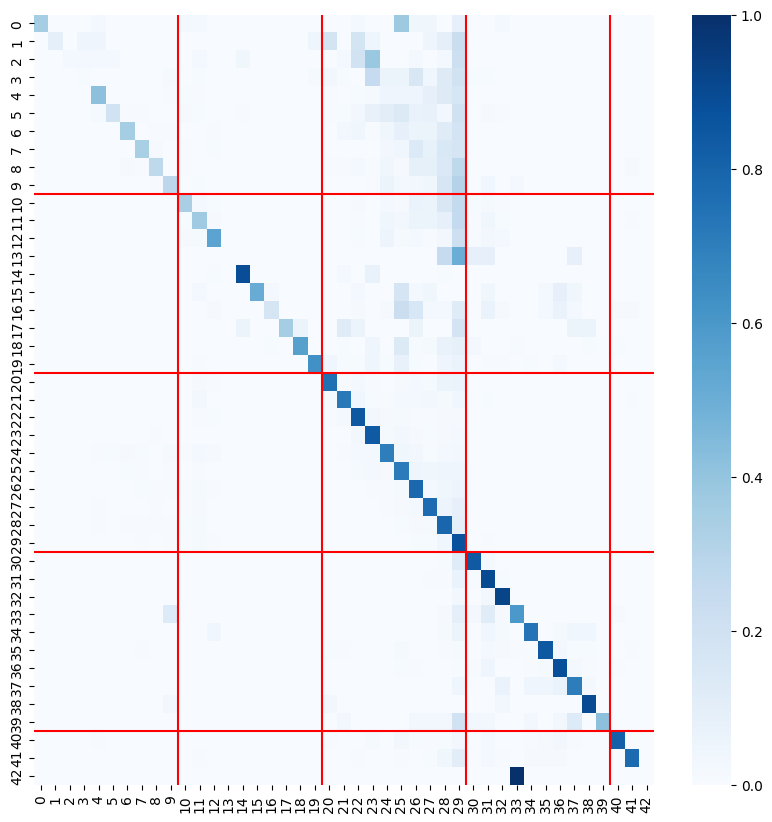

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

## Longformer

In [10]:
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/longformer-base-4096/decade_classifier_weights_3.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred.extend(predictions.detach().cpu().numpy())
        y_true.extend(labels.cpu().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [1:18:03<00:00,  1.37s/it]


In [14]:
task22 = mean_avg_error(np.array(y_true), np.array(y_pred))

task21 = mean_avg_error(np.array([ yt // 10 for yt in y_true]), np.array([ yp // 10 for yp in y_pred]))
print(f"Task 2.1: {task21}")
print(f"Task 2.2: {task22}")

Task 2.1: 0.1794294706409764
Task 2.2: 2.1999048507804067


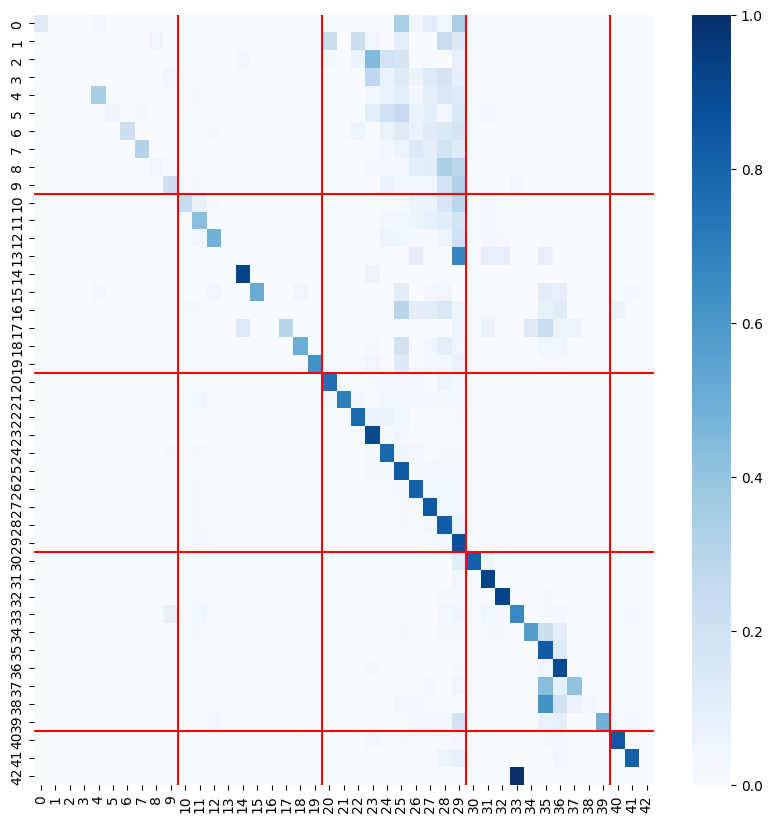

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

In [64]:
y_true_sg = []
y_pred_sg = []
for file_name, gt, pred in zip(X_valid_22, y_true, y_pred):
    with open(f'data/Task2/texts/valid/{file_name}', 'r') as f:
        text = f.read()
        if 'gutenberg' in text.lower():
            continue
        else:
            y_true_sg.append(gt)
            y_pred_sg.append(pred)

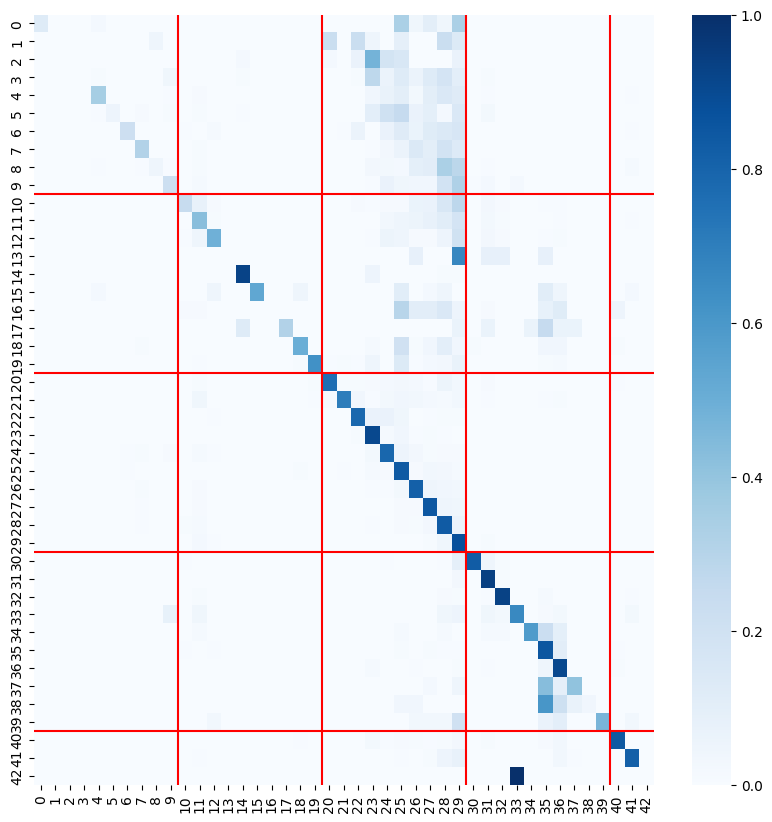

In [65]:
cm = confusion_matrix(y_true_sg, y_pred_sg)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

<Axes: >

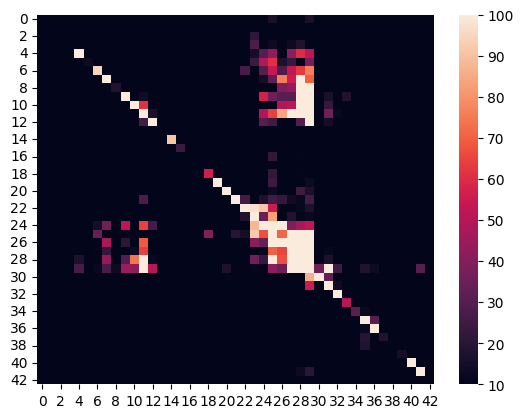

In [45]:
freq = np.zeros((43,43))
for b, c in zip(y_true, y_pred):
    freq[b,c] += 1
    
sns.heatmap(freq, vmin=10, vmax=100)

In [184]:
decade2year(33)

1930

In [49]:
for file_name, gt, pred in zip(X_valid_22, y_true, y_pred):
    if gt == 42 and pred == 33:
        # print(file_name, gt, pred)
        with open(f'data/Task2/texts/valid/{file_name}', 'r') as f:
            text = f.read()
            print(text[:120]) # 1948 https://www.gutenberg.org/files/64420/64420-h/64420-h.htm

a short interval the Heavy Belt would be touched. Then there would be real sickness. "Okay," said Kroll to Nibley. "You 


In [90]:
decade2year(12), decade2year(29)

(1720, 1890)

In [158]:
limit = 10
for file_name, gt, pred in zip(X_valid_22, y_true, y_pred):
    if gt <= 18 and pred >= 22:
        print(f'╔ {gt} ({decade2year(gt)}) - {pred} ({decade2year(pred)}) [{file_name}]')
        with open(f'data/Task2/texts/valid/{file_name}', 'r') as f:
            text = f.read()
            print(f'╚ {text[:80]}[...]')
        limit -= 1
        if limit == 0:
            break

╔ 12 (1720) - 29 (1890) [valid_text24071.txt]
╚ the Continent to the English coast. That my uncle fretted under the yoke of duty[...]
╔ 5 (1650) - 25 (1850) [valid_text9597.txt]
╚ uncompromising, patriotic counsel; let its fervency atone for its presumption Bo[...]
╔ 13 (1730) - 31 (1910) [valid_text26449.txt]
╚ wonÃ¢ÂÂt indeed!Ã¢ÂÂ said Isabel calmly, watching the dark shape at the door.[...]
╔ 5 (1650) - 29 (1890) [valid_text7360.txt]
╚ echo of the voices which Menie knows to be engaged in converse which must decide[...]
╔ 5 (1650) - 24 (1840) [valid_text5710.txt]
╚ heart for ever! Never presume to approach this house again.â With eyes blinded [...]
╔ 11 (1710) - 32 (1920) [valid_text22617.txt]
╚ glare of sunshine on all that was best of Neil and so giving unexpected glimpses[...]
╔ 9 (1690) - 29 (1890) [valid_text9754.txt]
╚ As I looked beyond his finger I saw four figures advance over the sward. One of [...]
╔ 11 (1710) - 28 (1880) [valid_text27646.txt]
╚ big enough, and bigly 

## Conformal

In [159]:
from sklearn.model_selection import train_test_split
# Split validation data into calibration and test sets
X_calib, X_test, y_calib, y_test = train_test_split(
    X_valid_22, y_valid_22, test_size=0.5, random_state=RANDOM_SEED
)

# Create datasets and dataloaders
calib_dataset = TextDataset(X_calib, y_calib, valid_path)
test_dataset = TextDataset(X_test, y_test, valid_path)
calib_dataloader = DataLoader(calib_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [160]:
%%capture

from transformers import BertTokenizer, BertModel
import numpy as np
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-cased")
model = BertModel.from_pretrained("google-bert/bert-base-cased")
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/decade_classifier_weights.pt'))
model_decade_classifier.to(device)
model_decade_classifier.eval()

In [162]:
# Get predictions and softmax probabilities for calibration set
calib_probs = []
calib_preds = []
calib_true = []

with torch.no_grad():
    for text, labels in tqdm(calib_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs.extend(probabilities.detach().cpu().numpy())
        calib_preds.extend(predictions.detach().cpu().numpy())
        calib_true.extend(labels.cpu().numpy())

# Compute nonconformity scores: 1 - probability of predicted class
nonconformity_scores = []
for i, prob in enumerate(calib_probs):
    pred = calib_preds[i]
    nonconformity_scores.append(1 - prob[pred])

# Set confidence level (e.g., 90%)
confidence_level = 0.90
alpha = 1 - confidence_level

# Find the threshold for the given confidence level
threshold = np.quantile(nonconformity_scores, 1 - alpha)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [07:56<00:00,  3.58it/s]


### Single threshold

In [169]:
# Evaluate on test set with prediction intervals
test_preds = []
test_intervals = []
test_true = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        
        # Get prediction intervals
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            
            # Include in prediction set all labels with nonconformity score <= threshold
            prediction_set = []
            for label in range(43):
                if 1 - prob[label].item() <= threshold:
                    prediction_set.append(label)
            
            test_preds.append(pred)
            test_intervals.append(prediction_set)
            test_true.append(labels[i].item())

# Calculate metrics
coverage = sum([true in interval for true, interval in zip(test_true, test_intervals)]) / len(test_true)
avg_interval_size = np.mean([len(interval) for interval in test_intervals])

print(f"BERT MAE: {mean_avg_error(np.array(test_true), np.array(test_preds))}")
print(f"Conformal prediction coverage: {coverage:.4f}")
print(f"Average prediction interval size: {avg_interval_size:.2f} decades")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [08:13<00:00,  3.46it/s]

BERT MAE: 2.453121569201493
Conformal prediction coverage: 0.7220
Average prediction interval size: 0.90 decades


### Multi thresholds

In [163]:
# Group calibration data by true class
class_nonconformity = {class_idx: [] for class_idx in range(43)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs, calib_true)):
    pred = calib_preds[i]
    nonconformity = 1 - prob[pred]
    class_nonconformity[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity.items():
    if len(scores) > 0:
        class_thresholds[class_idx] = np.quantile(scores, 1 - alpha)
    else:
        # Fallback for classes with no samples in calibration set
        class_thresholds[class_idx] = threshold  # Use global threshold as fallback


In [165]:
# Apply class-conditional thresholds when evaluating
test_preds2 = []
test_intervals2 = []
test_true2 = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds.get(label, threshold):
                    prediction_set.append(label)          
            test_preds2.append(pred)
            test_intervals2.append(prediction_set)
            test_true2.append(true_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [08:13<00:00,  3.46it/s]


Find the class that surpass the most the thresholds. Maybe, we should consider the magnitude? Since more populated classes tend to surpass with more ease the threshold (? to be verfied).


What if we make a threshold per century?

In [166]:
test_preds2 = []
test_intervals2 = []
test_true2 = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        
        for i, prob in enumerate(probabilities):
            true_label = labels[i].item()
            
            # Calculate margin for each class (how much it exceeds its threshold)
            margins = []
            for label in range(43):
                # Margin = probability - (1 - threshold)
                # This measures how far above the threshold the class is
                margin = prob[label].item() - (1 - class_thresholds.get(label, threshold))
                margins.append(margin)
            
            # Select class with highest margin as prediction
            pred = np.argmax(margins)
            
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                if 1 - prob[label].item() <= class_thresholds.get(label, threshold):
                    prediction_set.append(label)
            
            test_preds2.append(pred)
            test_intervals2.append(prediction_set)
            test_true2.append(true_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [08:26<00:00,  3.38it/s]


In [170]:
print(f"BERT MAE: {mean_avg_error(np.array(test_true), np.array(test_preds))}")

BERT MAE: 2.453121569201493


In [167]:
print(f"BERT MAE: {mean_avg_error(np.array(test_true2), np.array(test_preds2))}")

BERT MAE: 2.5322037619849227


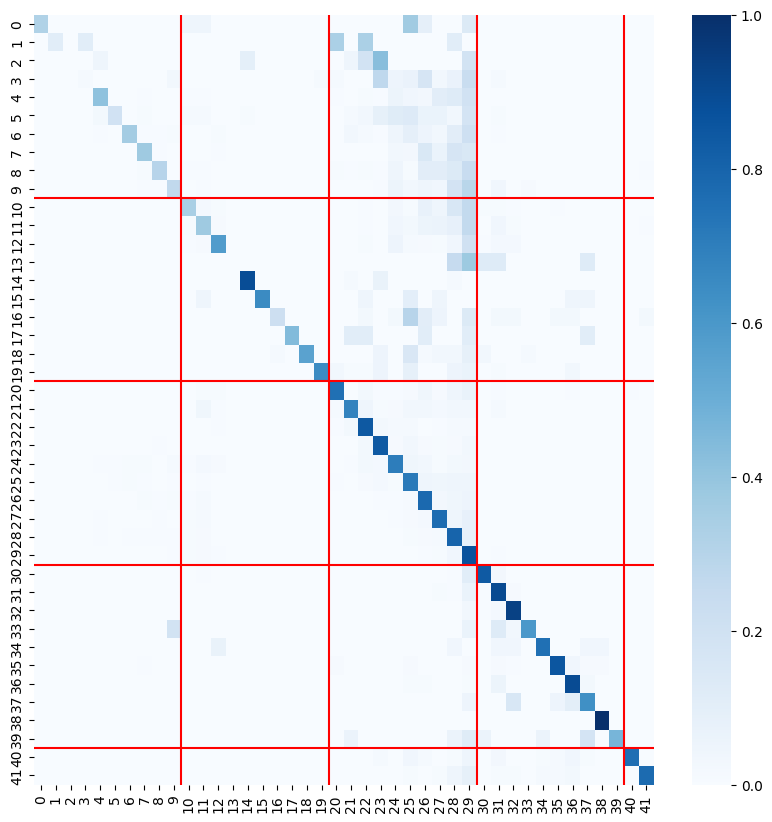

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_true, test_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show() 

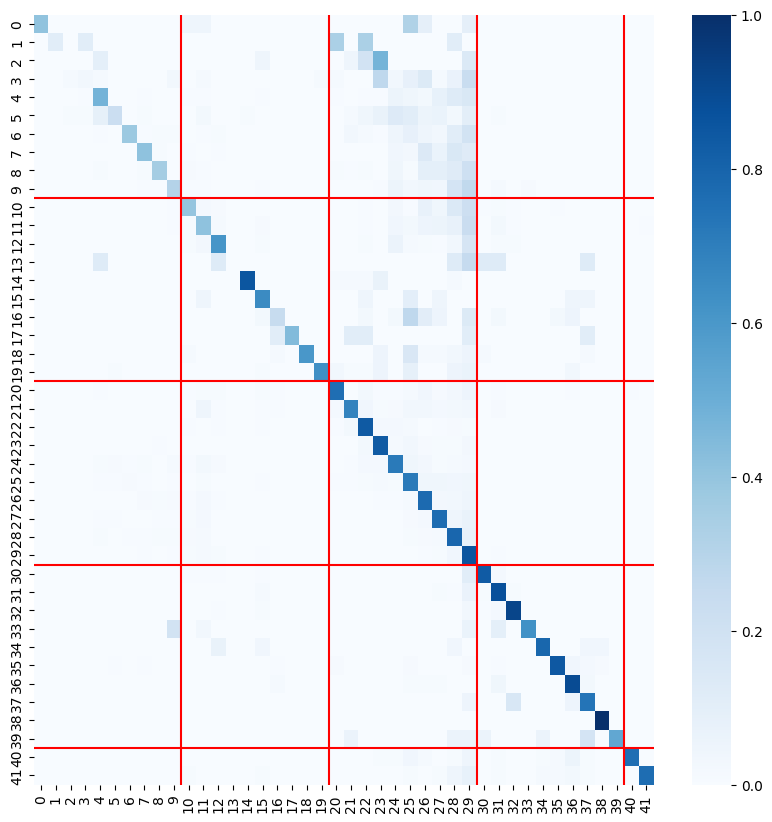

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_true2, test_preds2)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


[-0.35814809356816113, -0.28195483026211143, -0.28063769242726266, -0.3111813338939099, -0.28609701171517365, -0.2732078218832612, -0.39064557952806356, -0.34266602173447613, -0.344938234006986, -0.35734207928180695, -0.3484139271080494, -0.34548587575554834, -0.33797165527939765, -0.6135981920233462, -0.6066058173164491, -0.2581437900720629, -0.27344026709906755, -0.2771778313093819, -0.3623141232412308, -0.5079849805682894, -0.42359575942391525, -0.4665119859855622, -0.495820302516222, -0.4862821113318203, 0.12115482091903684, -0.42015212774276733, -0.44922122023999644, -0.49280153663130477, -0.5049453448504209, -0.4876276567578317, -0.5541193983517588, -0.7813756872201338, -0.7018380032968705, -0.5173530308296903, -0.4092396653286414, -0.45840852912515395, -0.3938409704482183, -0.3635511764441617, -0.3762488952779677, -0.306941468687728, -0.475433899089694, -0.5955182674922981, -0.2871217215360957]


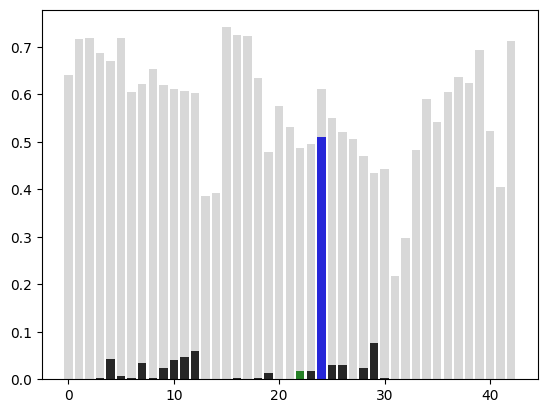

In [196]:
start = 15
for idx, (tt2, tp2) in enumerate(zip(test_true2[start:start+5], test_preds2[start:start+5])):
    if tt2 == tp2:
        continue

    idx += start
    text = test_dataset[idx][0]
    tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt").to(device)
    output = model_decade_classifier(**tokens)
    probabilities = torch.softmax(output, dim=1)

    margins = []
    for i, prob in enumerate(probabilities):
        true_label = labels[i].item()
        for label in range(43):
            # Margin = probability - (1 - threshold)
            # This measures how far above the threshold the class is
            margin = prob[label].item() - (1 - class_thresholds.get(label, threshold))
            margins.append(margin)
    print(margins)
    p_margin = np.argmax(margins)
    p_margin_prob = probabilities.squeeze().detach().cpu().numpy()[p_margin]

    plt.bar(range(43), probabilities[0].detach().cpu().numpy(), color='black')


    p_max = output.argmax(dim=1).squeeze().detach().cpu().numpy()
    p_max_prob = probabilities.squeeze().detach().cpu().numpy()[p_max]

    ground_truth = probabilities.squeeze().detach().cpu().numpy()[tt2] 

    
    plt.bar(p_max, p_max_prob, color='red', label='max')
    plt.bar(tt2, ground_truth, color='green', label='true')
    plt.bar(p_margin, p_margin_prob, color='blue', label='margin')

    for i, t in class_thresholds.items():
        plt.bar(i, t, color='grey', alpha=0.3)
    # plt.axvline(tt2, color='black')
    
    plt.show()

#### Longformer

In [177]:
%%capture

from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/longformer-base-4096/decade_classifier_weights_3.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()

In [178]:
# Get predictions and softmax probabilities for calibration set
calib_probs_longformer = []
calib_preds_longformer = []
calib_true_longformer = []

with torch.no_grad():
    for text, labels in tqdm(calib_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs_longformer.extend(probabilities.detach().cpu().numpy())
        calib_preds_longformer.extend(predictions.detach().cpu().numpy())
        calib_true_longformer.extend(labels.cpu().numpy())

# Compute nonconformity scores: 1 - probability of predicted class
nonconformity_scores_longformer = []
for i, prob in enumerate(calib_probs_longformer):
    pred = calib_preds_longformer[i]
    nonconformity_scores_longformer.append(1 - prob[pred])

# Set confidence level (e.g., 90%)
confidence_level = 0.90
alpha = 1 - confidence_level

# Find the threshold for the given confidence level
threshold_longformer = np.quantile(nonconformity_scores_longformer, 1 - alpha)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [13:56<00:00,  2.04it/s]


In [179]:
# Group calibration data by true class
class_nonconformity_longformer = {class_idx: [] for class_idx in range(43)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs_longformer, calib_true_longformer)):
    pred = calib_preds[i]
    nonconformity = 1 - prob[pred]
    class_nonconformity_longformer[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_longformer = {}
confidence_level = 0.90
alpha = 1 - confidence_level

for class_idx, scores in class_nonconformity_longformer.items():
    if len(scores) > 0:
        class_thresholds_longformer[class_idx] = np.quantile(scores, 1 - alpha)
    else:
        # Fallback for classes with no samples in calibration set
        class_thresholds_longformer[class_idx] = threshold_longformer  # Use global threshold as fallback


In [180]:
# Apply class-conditional thresholds when evaluating
test_preds_longformer = []
test_intervals_longformer = []
test_true_longformer = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds.get(label, threshold_longformer):
                    prediction_set.append(label)          
            test_preds_longformer.append(pred)
            test_intervals_longformer.append(prediction_set)
            test_true_longformer.append(true_label)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [14:21<00:00,  1.98it/s]


In [181]:
coverage = sum([true in interval for true, interval in zip(test_true_longformer, test_intervals_longformer)]) / len(test_true_longformer)
avg_interval_size = np.mean([len(interval) for interval in test_intervals_longformer])

print(f"BERT MAE: {mean_avg_error(np.array(test_true_longformer), np.array(test_preds_longformer))}")
print(f"Conformal prediction coverage: {coverage:.4f}")
print(f"Average prediction interval size: {avg_interval_size:.2f} decades")

BERT MAE: 2.1891971016614216
Conformal prediction coverage: 0.7329
Average prediction interval size: 0.87 decades


In [207]:
test_true_zero = []
test_pred_zero = []

test_true_single = []
test_pred_single = []

test_true_multiple = []
test_pred_multiple = []

for tt, ti, tp in zip(test_true_longformer, test_intervals_longformer, test_preds_longformer):
    if len(ti) == 0:
        test_true_zero.append(tt)
        test_pred_zero.append(tp) # max?
    elif len(ti) == 1:
        test_true_single.append(tt)
        test_pred_single.append(ti[0])
    else:
        test_true_multiple.append(tt)
        test_pred_multiple.append(ti)

In [208]:
len(test_true_single), len(test_true_multiple), len(test_true_zero), len(test_true_longformer)

(23591, 23, 3712, 27326)

In [213]:
print(f"Zero (MAE): {mean_avg_error(np.array(test_true_zero), np.array(test_pred_zero))}")

print(f"Single (MAE): {mean_avg_error(np.array(test_true_single), np.array(test_pred_single))}")

print(f"Multiple coverage: {np.mean([ x in y for x, y in zip(test_true_multiple, test_pred_multiple)])}")

print(f"Total (MAE): {mean_avg_error(np.array(y_true_temp), np.array(y_pred_temp))}")

Zero (MAE): 6.299299568965517
Single (MAE): 1.5377898351066084
Multiple coverage: 1.0
Total (MAE): 2.1891971016614216


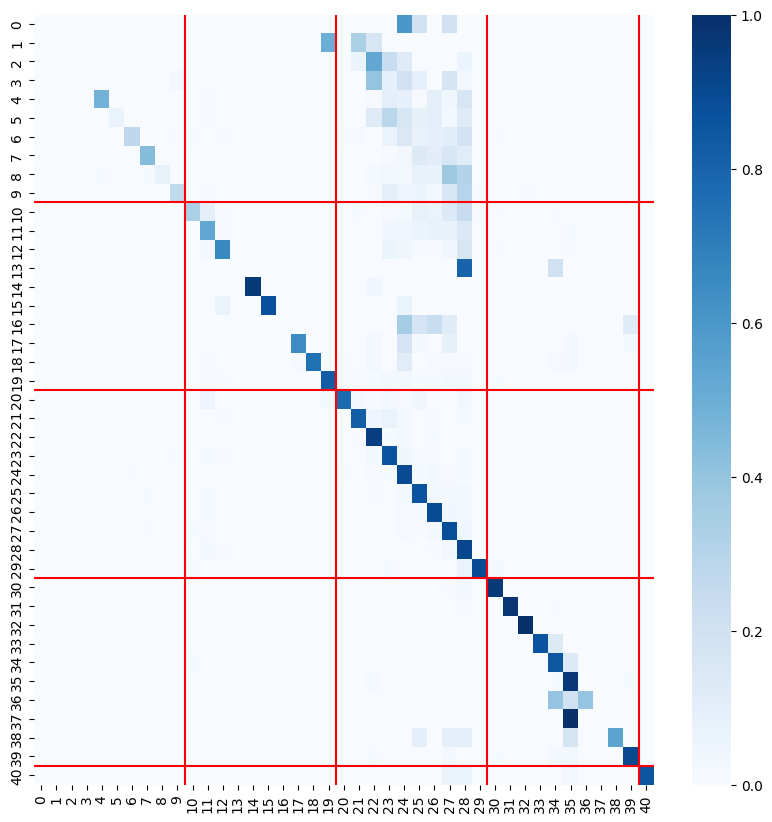

In [193]:
cm = confusion_matrix(test_true_single, test_pred_single)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues')
# make rectangles grouping the decades
plt.axvline(10, color='red')
plt.axvline(20, color='red')
plt.axvline(30, color='red')
plt.axvline(40, color='red')
plt.axhline(10, color='red')
plt.axhline(20, color='red')
plt.axhline(30, color='red')
plt.axhline(40, color='red')
plt.show()

In [318]:
# Test just on the documents containing an encoding problem

test_w_ep = [ True if 'Ã' in test_text else False for test_text, _ in test_dataset]

print(mean_avg_error(np.array(test_true_longformer)[test_w_ep], np.array(test_preds_longformer)[test_w_ep]))

test_wo_ep = [ not x for x in test_w_ep]

print(mean_avg_error(np.array(test_true_longformer)[test_wo_ep], np.array(test_preds_longformer)[test_wo_ep]))

2.076246648793566
2.2477084606410753


25 tensor(25)


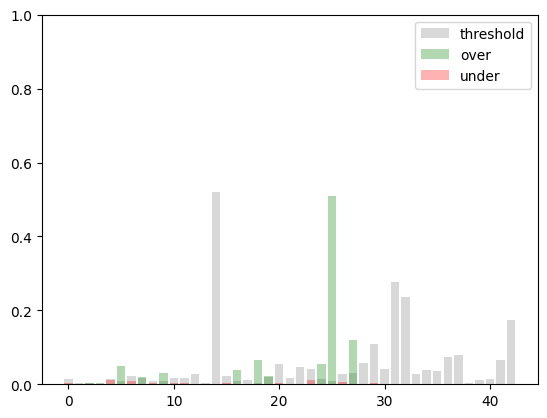

In [280]:
ex_prob = probabilities[2].detach().cpu().numpy()

print(np.argmax(ex_prob), labels[2])
oks = [ x if 1 - x <= y else 0  for x, y in zip(ex_prob, class_thresholds_longformer.values()) ]
not_oks = [ x if 1 - x > y else 0  for x, y in zip(ex_prob, class_thresholds_longformer.values()) ]

plt.bar(class_thresholds_longformer.keys(), [ 1 - x for x in class_thresholds_longformer.values()], color='grey', alpha=0.3, label='threshold')
#plt.bar(range(43), ex_prob, alpha=0.3)
plt.bar(range(43), oks, alpha=0.3, color='green', label='over')
plt.bar(range(43), not_oks, alpha=0.3, color='red', label='under')
plt.ylim(0,1)
plt.legend()

In [741]:
test_preds_longformer2 = []
test_intervals_longformer2 = []
test_true_longformer2 = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)    
        #print(predictions)
        #print(probabilities)
        break
        for i, prob in enumerate(probabilities):
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds.get(label, threshold_longformer):
                    prediction_set.append(label)          
            test_preds_longformer2.append(pred)
            test_intervals_longformer2.append(prediction_set)
            test_true_longformer2.append(true_label)

  0%|                                                                                                                                                                                        | 0/1708 [00:00<?, ?it/s]


#### Alternative calibration

In [342]:
# Group calibration data by true class
class_nonconformity_longformer2 = {class_idx: [] for class_idx in range(43)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs_longformer, calib_true_longformer)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_longformer2[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_longformer2 = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_true_longformer)
for class_idx, scores in class_nonconformity_longformer2.items():
    if len(scores) > 0:
        # class_thresholds_longformer2[class_idx] = np.quantile(scores, 1 - alpha)
        q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
        class_thresholds_longformer2[class_idx] = np.quantile(scores, q) 
    else:
        # Fallback for classes with no samples in calibration set
        class_thresholds_longformer2[class_idx] = threshold_longformer  # Use global threshold as fallback


In [477]:
test_preds_longformer3 = []
test_intervals_longformer3 = []
test_true_longformer3 = []
test_probs_longformer3 = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_longformer2[label]:
                    prediction_set.append(label)  
                    
            test_preds_longformer3.append(pred)
            test_intervals_longformer3.append(prediction_set)
            test_true_longformer3.append(true_label)
            test_probs_longformer3.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [14:36<00:00,  1.95it/s]


In [344]:
print(f"Longformer coverage: {np.mean([ x in y for x, y in zip(test_true_longformer, test_intervals_longformer)])}")
print("Avg interval length:", np.mean([len(interval) for interval in test_intervals_longformer]))
print()
print(f"Longformer3 coverage: {np.mean([ x in y for x, y in zip(test_true_longformer3, test_intervals_longformer3)])}")
print("Avg interval length:", np.mean([len(interval) for interval in test_intervals_longformer3]))

Longformer coverage: 0.7329283466295835
Avg interval length: 0.8650003659518407

Longformer3 coverage: 0.9008636463441411
Avg interval length: 4.048049476688868


In [347]:
test_true_zero3 = []
test_pred_zero3 = []

test_true_single3 = []
test_pred_single3 = []

test_true_multiple3 = []
test_pred_multiple3 = []

for tt, ti, tp in zip(test_true_longformer3, test_intervals_longformer3, test_preds_longformer3):
    if len(ti) == 0:
        test_true_zero3.append(tt)
        test_pred_zero3.append(tp) # max?
    elif len(ti) == 1:
        test_true_single3.append(tt)
        test_pred_single3.append(ti[0])
    else:
        test_true_multiple3.append(tt)
        test_pred_multiple3.append(ti)

In [372]:
len(test_pred_zero3), len(test_pred_single3), len(test_pred_multiple3)

(0, 12356, 14970)

In [369]:
print(f"Single (MAE): {mean_avg_error(np.array(test_true_single3), np.array(test_pred_single3))}")

print(f"Coverage (Multiple): {np.mean([ x in y for x, y in zip(test_true_multiple3, test_pred_multiple3)])}")
print(f"Avg interval size : {np.mean([len(interval) for interval in test_pred_multiple3])}")

Single (MAE): 0.16963418582065393
Coverage (Multiple): 0.8380093520374081
Avg interval size : 6.563861055444222


/tmp/ipykernel_559954/1565605286.py:6: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


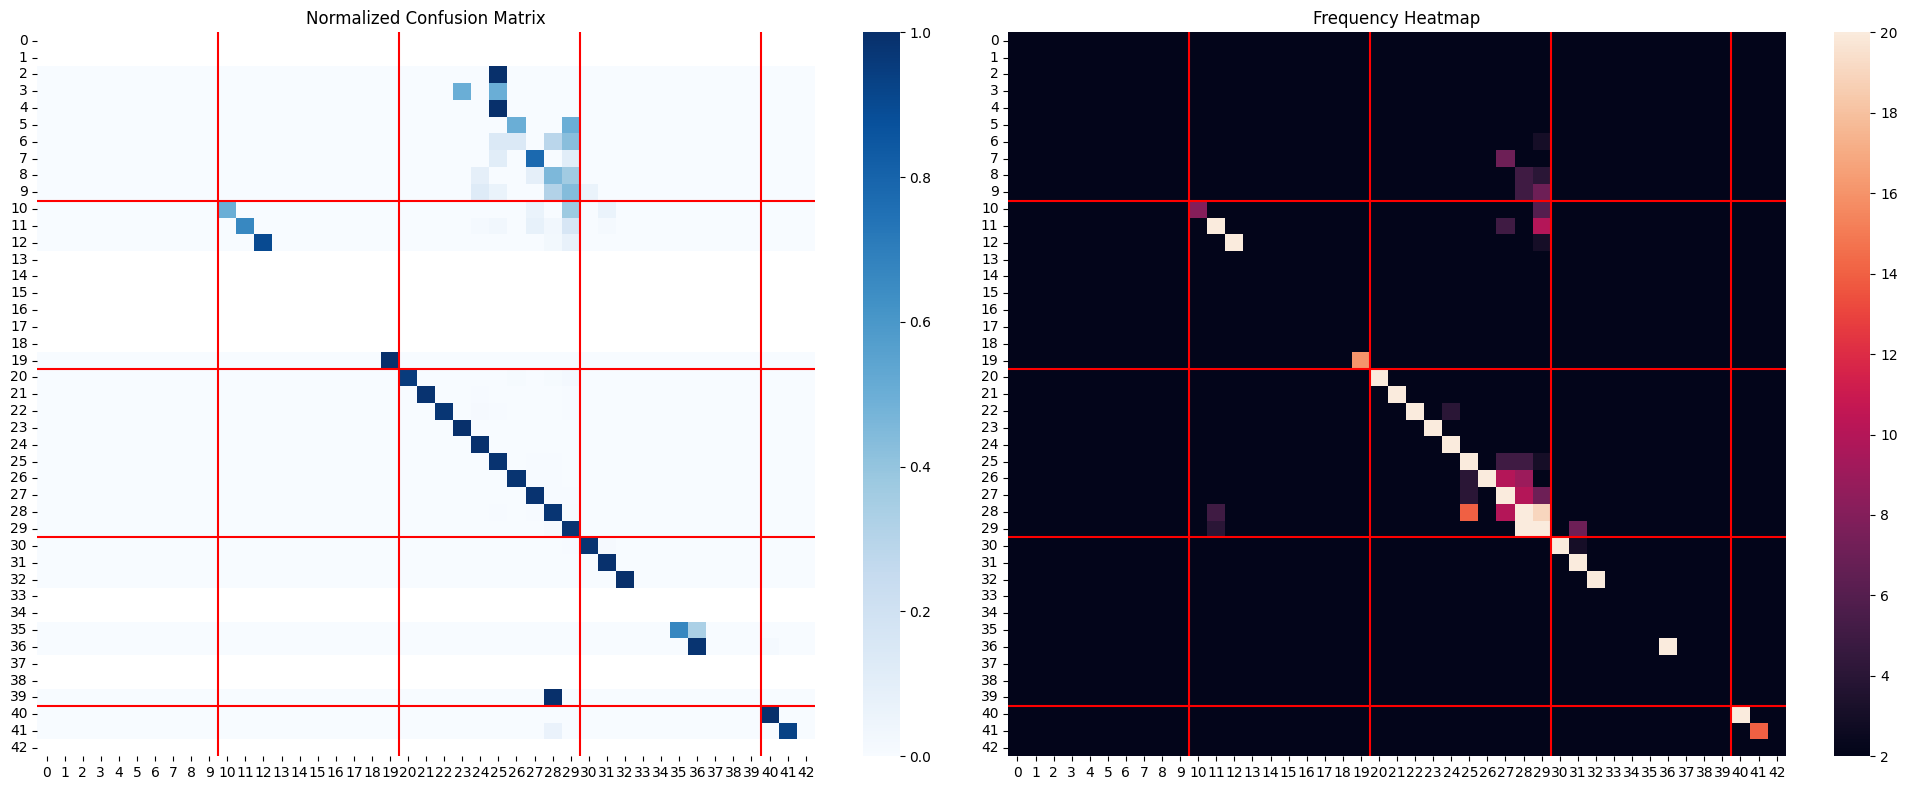

In [405]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

tick_positions = np.arange(43)

cm = confusion_matrix(test_true_single3, test_pred_single3, labels=np.arange(43))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, cmap='Blues', ax=ax1)

ax1.set_xticks(tick_positions + 0.5)
ax1.set_xticklabels(tick_positions)
ax1.set_title('Normalized Confusion Matrix')


freq3 = np.zeros((43,43))
for b, c in zip(test_true_single3, test_pred_single3):
    freq3[b,c] += 1
    
sns.heatmap(freq3, vmin=2, vmax=20, cmap='rocket', ax=ax2)

ax2.set_xticks(tick_positions + 0.5)
ax2.set_xticklabels(tick_positions)
ax2.set_title('Frequency Heatmap')

for dec_line in range(10,50,10):
    ax1.axvline(dec_line, color='red')
    ax1.axhline(dec_line, color='red')
    ax2.axvline(dec_line, color='red')
    ax2.axhline(dec_line, color='red')
    
plt.tight_layout()
plt.show()

[29] Pred: 9 - True 24
[1, 2, 3, 5, 6, 7, 8, 9, 24]
9


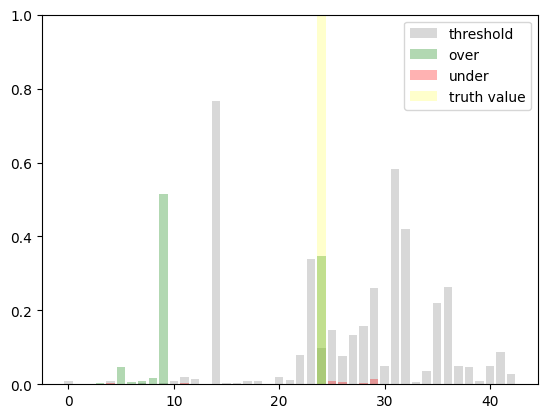

[35] Pred: 29 - True 10
[9, 10, 11, 12, 29]
29


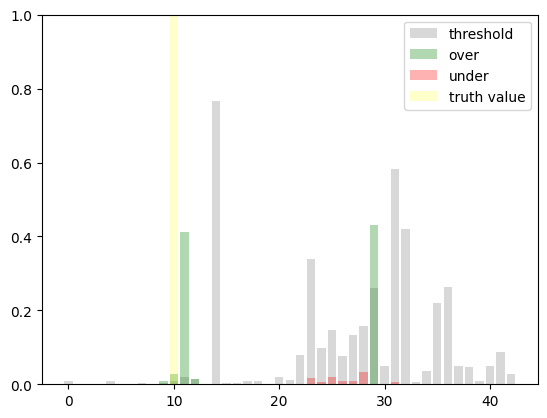

[45] Pred: 29 - True 39
[1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 19, 29, 30, 39]
29


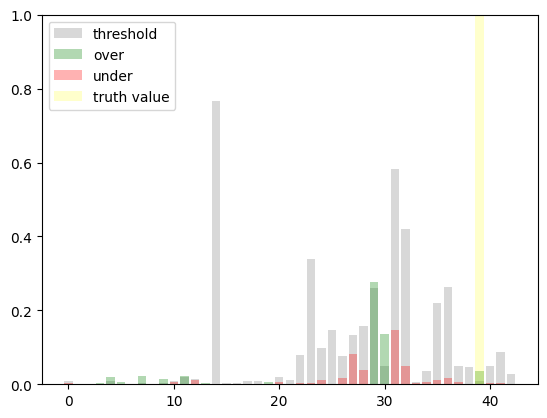

[46] Pred: 29 - True 8
[3, 5, 6, 7, 8, 9, 29]
29


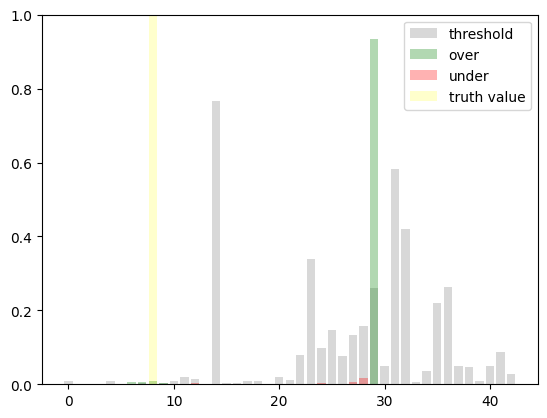

[56] Pred: 9 - True 24
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24]
9


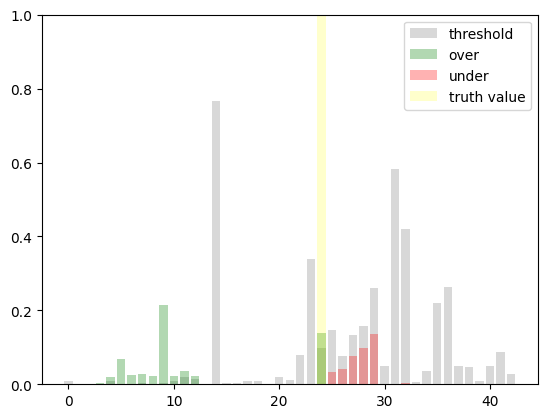

In [578]:
limit = 5
for idx in range(len(test_probs_longformer3)):
    ex_prob = test_probs_longformer3[idx]
    if np.argmax(ex_prob) == test_true_longformer3[idx]:
        continue
        
    if abs(np.argmax(ex_prob) - test_true_longformer3[idx]) < 5:
        continue
        
    print(f"[{idx}] Pred: {np.argmax(ex_prob)} - True {test_true_longformer3[idx]}")
    print(test_intervals_longformer3[idx])
    print(test_preds_longformer3[idx])
    oks = [ x if 1 - x <= y else 0  for x, y in zip(ex_prob, class_thresholds_longformer2.values()) ]
    not_oks = [ x if 1 - x > y else 0  for x, y in zip(ex_prob, class_thresholds_longformer2.values()) ]

    plt.bar(class_thresholds_longformer2.keys(), [ 1 - x for x in class_thresholds_longformer2.values()], color='grey', alpha=0.3, label='threshold')
    #plt.bar(range(43), ex_prob, alpha=0.3)
    plt.bar(range(43), oks, alpha=0.3, color='green', label='over')
    plt.bar(range(43), not_oks, alpha=0.3, color='red', label='under')
    
    gt = np.zeros(43)
    gt[test_true_longformer3[idx]] = 1
    plt.bar(range(43), gt, alpha=0.2, color='yellow', label='truth value')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
    limit -= 1
    if limit == 0:
        break

In [537]:
[ 1 - x for x in class_thresholds_longformer2.values()][24]

0.098044834522239

In [576]:
# Take the ones that exeed the most the threshold 

test_preds_argmax_longformer3 = []
test_preds_var_longformer3 = []
test_preds_var_rel_longformer3 = []

test_true_var_longformer3 = []
thslds = [ 1 - x for x in class_thresholds_longformer2.values()]

for idx in range(len(test_probs_longformer3)):
    intervals = test_intervals_longformer3[idx]
    if len(intervals) == 1:
        continue
    true_label = test_true_longformer3[idx]
    probs = test_probs_longformer3[idx]
    
    exeeding_idx = np.zeros(43)
    exeeding_rel_idx = np.zeros(43)
    
    for interval in intervals:
        if probs[interval] > thslds[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds[interval]) / probs[interval]
            
    test_preds_argmax_longformer3.append(np.argmax(probs))
    test_preds_var_longformer3.append(np.argmax(exeeding_idx))
    test_preds_var_rel_longformer3.append(np.argmax(exeeding_rel_idx))
    test_true_var_longformer3.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_argmax_longformer3))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_var_longformer3))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_var_rel_longformer3))}")

argmax (MAE): 3.8561122244488977
variance (MAE): 3.9975283901135605
variance rel (MAE): 8.698864395457582


[46] Pred: 29 - True 8
[3, 5, 6, 7, 8, 9, 29]
 argmax: 29
 var: 7
 var rel:7
[0.         0.         0.         0.00404676 0.         0.00601079
 0.         0.02037464 0.00052488 0.01037277 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0170404
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
[0.         0.         0.         7.45001331 0.         5.56245885
 0.         9.07055056 0.35155226 3.67840098 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.06551436
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
29


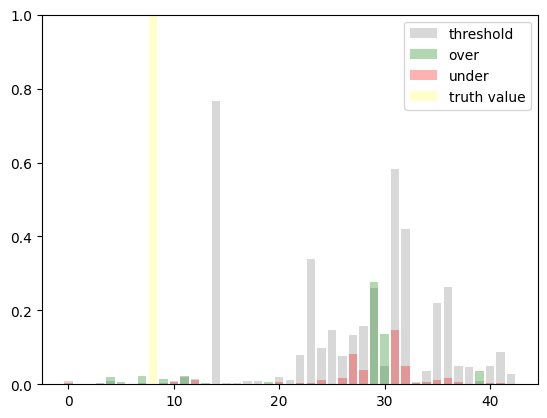

mother; but nature is strong, and I suppose there comes a time in every one's life when he must speak to some one as he would to a mother. You have been very kind, dear aunt, and I shall never forget that you have wished and schemed for my happiness." The old lady came and put her arm around the young man's neck and looked into his face with a strange wistfulness as she said, slowly: "There is no blood relationship between us, Alford, but we are nearer akin than such ties could make us. You do not remember your mother; I never had a child. But, as you say, nature is strong; and although I have tried to satisfy myself with a hundred things, the mother in my heart has never been content. I hoped, I prayed, that you and Grace might become my children. Alford, I have been learning of late that I am a lonely, unhappy old woman. Will you not be my boy? I would rather share your sorrow than be alone in the world again." Graham was deeply touched. He bowed his head upon her shoulder as if he w

In [601]:
idx = 46
intervals = test_intervals_longformer3[idx]

true_label = test_true_longformer3[idx]
ex_probs = test_probs_longformer3[idx]

exeeding_idx = np.zeros(43)
exeeding_rel_idx = np.zeros(43)

print(f"[{idx}] Pred: {np.argmax(ex_prob)} - True {test_true_longformer3[idx]}")
print(test_intervals_longformer3[idx])

for interval in intervals:
    if probs[interval] > thslds[interval]:

        exeeding_idx[interval] = abs(probs[interval]-thslds[interval])

        exeeding_rel_idx[interval] = abs(probs[interval]-thslds[interval]) / thslds[interval]
        
print(f" argmax: {np.argmax(ex_probs)}")
print(f" var: {np.argmax(exeeding_idx)}")
print(f" var rel:{np.argmax(exeeding_rel_idx)}")

print(exeeding_idx)
print(exeeding_rel_idx)

print(test_preds_longformer3[idx])
oks = [ x if 1 - x <= y else 0  for x, y in zip(ex_prob, class_thresholds_longformer2.values()) ]
not_oks = [ x if 1 - x > y else 0  for x, y in zip(ex_prob, class_thresholds_longformer2.values()) ]

plt.bar(class_thresholds_longformer2.keys(), [ 1 - x for x in class_thresholds_longformer2.values()], color='grey', alpha=0.3, label='threshold')
#plt.bar(range(43), ex_prob, alpha=0.3)
plt.bar(range(43), oks, alpha=0.3, color='green', label='over')
plt.bar(range(43), not_oks, alpha=0.3, color='red', label='under')

gt = np.zeros(43)
gt[test_true_longformer3[idx]] = 1
plt.bar(range(43), gt, alpha=0.2, color='yellow', label='truth value')
plt.ylim(0,1)
plt.legend()
plt.show()

print(test_dataset[idx][0])

#### Clean Text 

In [799]:
calib_dataset = TextDataset(X_calib, y_calib, valid_path)
test_dataset = TextDataset(X_test, y_test, valid_path)
calib_dataloader = DataLoader(calib_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

calib_dataset_clean = TextDataset(X_calib, y_calib, valid_path, clear=True)
test_dataset_clean = TextDataset(X_test, y_test, valid_path, clear=True)
calib_dataloader_clean = DataLoader(calib_dataset_clean, batch_size=16, shuffle=False)
test_dataloader_clean = DataLoader(test_dataset_clean, batch_size=16, shuffle=False)

In [769]:
%%capture

from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)
    
model_decade_classifier_clean = BertForSequenceClassification(model, 43)
model_decade_classifier_clean.load_state_dict(torch.load('models/longformer-base-4096/decade_classifier_weights_3_cleantext.pt'))
model_decade_classifier_clean.to(device)

model_decade_classifier_clean.eval()

In [770]:
# Calibration
calib_probs_longformer_clean = []
calib_preds_longformer_clean = []
calib_true_longformer_clean = []

with torch.no_grad():
    for text, labels in tqdm(calib_dataloader_clean):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier_clean(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs_longformer_clean.extend(probabilities.detach().cpu().numpy())
        calib_preds_longformer_clean.extend(predictions.detach().cpu().numpy())
        calib_true_longformer_clean.extend(labels.cpu().numpy())
        
calib_probs_longformer_notclean = []
calib_preds_longformer_notclean = []
calib_true_longformer_notclean = []

with torch.no_grad():
    for text, labels in tqdm(calib_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier_clean(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs_longformer_notclean.extend(probabilities.detach().cpu().numpy())
        calib_preds_longformer_notclean.extend(predictions.detach().cpu().numpy())
        calib_true_longformer_notclean.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [14:00<00:00,  2.03it/s]


In [801]:
# Group calibration data by true class
class_nonconformity_longformer_clean = {class_idx: [] for class_idx in range(43)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs_longformer_clean, calib_true_longformer_clean)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_longformer_clean[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_longformer_clean = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_true_longformer_clean)
for class_idx, scores in class_nonconformity_longformer_clean.items():
    # class_thresholds_longformer2[class_idx] = np.quantile(scores, 1 - alpha)
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_longformer_clean[class_idx] = np.quantile(scores, q) 
        
# Not clean =========================================================================
class_nonconformity_longformer_notclean = {class_idx: [] for class_idx in range(43)}

for i, (prob, true_label) in enumerate(zip(calib_probs_longformer_notclean, calib_true_longformer_notclean)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_longformer_notclean[true_label].append(nonconformity)

class_thresholds_longformer_notclean = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_true_longformer_notclean)
for class_idx, scores in class_nonconformity_longformer_notclean.items():
    # class_thresholds_longformer2[class_idx] = np.quantile(scores, 1 - alpha)
    q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
    class_thresholds_longformer_notclean[class_idx] = np.quantile(scores, q) 

In [802]:
test_preds_longformer_clean = []
test_intervals_longformer_clean = []
test_true_longformer_clean = []
test_probs_longformer_clean = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader_clean):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier_clean(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_longformer_clean[label]:
                    prediction_set.append(label)  
                    
            test_preds_longformer_clean.append(pred)
            test_intervals_longformer_clean.append(prediction_set)
            test_true_longformer_clean.append(true_label)
            test_probs_longformer_clean.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [17:08<00:00,  1.66it/s]


In [775]:
test_preds_longformer_notclean = []
test_intervals_longformer_notclean = []
test_true_longformer_notclean = []
test_probs_longformer_notclean = []

with torch.no_grad():
    for text, labels in tqdm(test_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier_clean(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_longformer_notclean[label]:
                    prediction_set.append(label)  
                    
            test_preds_longformer_notclean.append(pred)
            test_intervals_longformer_notclean.append(prediction_set)
            test_true_longformer_notclean.append(true_label)
            test_probs_longformer_notclean.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1708/1708 [14:17<00:00,  1.99it/s]


In [811]:
test_preds_argmax_longformer_clean = []
test_preds_var_longformer_clean = []
test_preds_var_rel_longformer_clean = []

test_true_var_longformer_clean = []
thslds_clean = [ 1 - x for x in class_thresholds_longformer_clean.values()]

for idx in range(len(test_probs_longformer_clean)):
    intervals = test_intervals_longformer_clean[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_longformer_clean[idx]
    probs = test_probs_longformer_clean[idx]
    
    exeeding_idx = np.zeros(43)
    exeeding_rel_idx = np.zeros(43)
    
    for interval in intervals:
        if probs[interval] > thslds_clean[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_clean[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_clean[interval]) / probs[interval]
            
    test_preds_argmax_longformer_clean.append(np.argmax(probs))
    test_preds_var_longformer_clean.append(np.argmax(exeeding_idx))
    test_preds_var_rel_longformer_clean.append(np.argmax(exeeding_rel_idx))
    test_true_var_longformer_clean.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_longformer_clean), np.array(test_preds_argmax_longformer_clean))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_longformer_clean), np.array(test_preds_var_longformer_clean))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_longformer_clean), np.array(test_preds_var_rel_longformer_clean))}")

argmax (MAE): 2.4166727658640124
variance (MAE): 2.4166361706799386
variance rel (MAE): 5.20643343336017


In [846]:
test_preds_argmax_longformer_notclean = []
test_preds_var_longformer_notclean = []
test_preds_var_rel_longformer_notclean = []

test_true_var_longformer_notclean = []
thslds_notclean = [ 1 - x for x in class_thresholds_longformer_notclean.values()]

for idx in range(len(test_probs_longformer_notclean)):
    intervals = test_intervals_longformer_notclean[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_longformer_notclean[idx]
    probs = test_probs_longformer_notclean[idx]
    
    exeeding_idx = np.zeros(43)
    exeeding_rel_idx = np.zeros(43)
    
    for interval in intervals:
        if probs[interval] > thslds_notclean[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_notclean[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_notclean[interval]) / probs[interval]
            
    test_preds_argmax_longformer_notclean.append(np.argmax(probs))
    test_preds_var_longformer_notclean.append(np.argmax(exeeding_idx))
    test_preds_var_rel_longformer_notclean.append(np.argmax(exeeding_rel_idx))
    test_true_var_longformer_notclean.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_longformer_notclean), np.array(test_preds_argmax_longformer_notclean))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_longformer_notclean), np.array(test_preds_var_longformer_notclean))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_longformer_notclean), np.array(test_preds_var_rel_longformer_notclean))}")

argmax (MAE): 2.3186708629144404
variance (MAE): 2.33543145722023
variance rel (MAE): 4.733623655126985


In [847]:
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_argmax_longformer3))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_var_longformer3))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_longformer3), np.array(test_preds_var_rel_longformer3))}")

argmax (MAE): 3.8561122244488977
variance (MAE): 3.9975283901135605
variance rel (MAE): 8.698864395457582


In [848]:
# Task 2.1
print("Model trained on noisy data")
print(f" * argmax (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer3]), np.array([ x // 10 for x in test_preds_argmax_longformer3]))}")
print(f" * variance (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer3]), np.array([ x // 10 for x in test_preds_var_longformer3]))}")
print(f" * variance rel (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer3]), np.array([ x // 10 for x in test_preds_var_rel_longformer3]))}")
print()
print("Model trained on clean data and tested on noisy data")
print(f" * argmax (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_notclean]), np.array([ x // 10 for x in test_preds_argmax_longformer_notclean]))}")
print(f" * variance (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_notclean]), np.array([ x // 10 for x in test_preds_var_longformer_notclean]))}")
print(f" * variance rel (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_notclean]), np.array([ x // 10 for x in test_preds_var_rel_longformer_notclean]))}")
print()
print("Model trained on clean data and tested on clean data")
print(f" * argmax (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_clean]), np.array([ x // 10 for x in test_preds_argmax_longformer_clean]))}")
print(f" * variance (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_clean]), np.array([ x // 10 for x in test_preds_var_longformer_clean]))}")
print(f" * variance rel (MAE): {mean_avg_error(np.array([ x // 10 for x in test_true_var_longformer_clean]), np.array([ x // 10 for x in test_preds_var_rel_longformer_clean]))}")

Model trained on noisy data
 * argmax (MAE): 0.3136940547762191
 * variance (MAE): 0.3240480961923848
 * variance rel (MAE): 0.7814963259853039

Model trained on clean data and tested on noisy data
 * argmax (MAE): 0.1926004537802825
 * variance (MAE): 0.19450340335211885
 * variance rel (MAE): 0.42841981995169437

Model trained on clean data and tested on clean data
 * argmax (MAE): 0.19706506623728318
 * variance (MAE): 0.19896801580911952
 * variance rel (MAE): 0.46373417258288807


## When is it wrong?

In [ ]:

for tt, ti, tp in zip(test_true_longformer, test_intervals_longformer, test_preds_longformer):
    if len(ti) == 0:
        test_true_zero3.append(tt)
        test_pred_zero3.append(tp) # max?
    elif len(ti) == 1:
        test_true_single3.append(tt)
        test_pred_single3.append(ti[0])
    else:
        test_true_multiple3.append(tt)
        test_pred_multiple3.append(ti)

In [876]:
test_true_longformer3_zero = []
test_preds_argmax_longformer3_zero = []

test_true_longformer3_single = []
test_preds_argmax_longformer3_single = []

test_true_longformer3_multiple = []
test_preds_argmax_longformer3_multiple = []
test_new_preds_argmax_longformer3_multiple = []
test_intervals_longformer3_multiple = []

test_true_var_longformer3 = []
thslds = [ 1 - x for x in class_thresholds_longformer2.values()]

for idx in range(len(test_probs_longformer3)):
    intervals = test_intervals_longformer3[idx]
    #if len(intervals) == 1:
    #    continue
    true_label = test_true_longformer3[idx]
    probs = test_probs_longformer3[idx]
    
    exeeding_idx = np.zeros(43)
    exeeding_rel_idx = np.zeros(43)
    
    for interval in intervals:
        if probs[interval] > thslds[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds[interval]) / probs[interval]
    
    if len(intervals) == 0:
        test_preds_argmax_longformer3_zero.append(np.argmax(probs))
        #test_preds_var_longformer3.append(np.argmax(exeeding_idx))
        #test_preds_var_rel_longformer3.append(np.argmax(exeeding_rel_idx))
        test_true_longformer3_zero.append(true_label)
    elif len(intervals) == 1:
        test_preds_argmax_longformer3_single.append(np.argmax(probs))
        test_true_longformer3_single.append(true_label)
    else:
        test_preds_argmax_longformer3_multiple.append(np.argmax(probs))
        test_true_longformer3_multiple.append(true_label)
        test_intervals_longformer3_multiple.append(intervals)
        new_probs = [ prob if idx // 10 != 2 else 0 for idx, prob in enumerate(probs)]
        test_new_preds_argmax_longformer3_multiple.append(np.argmax(new_probs))
        

In [862]:
len(test_true_longformer3_zero), len(test_true_longformer3_single), len(test_true_longformer3_multiple)

(0, 12356, 14970)

/tmp/ipykernel_559954/1851294567.py:6: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


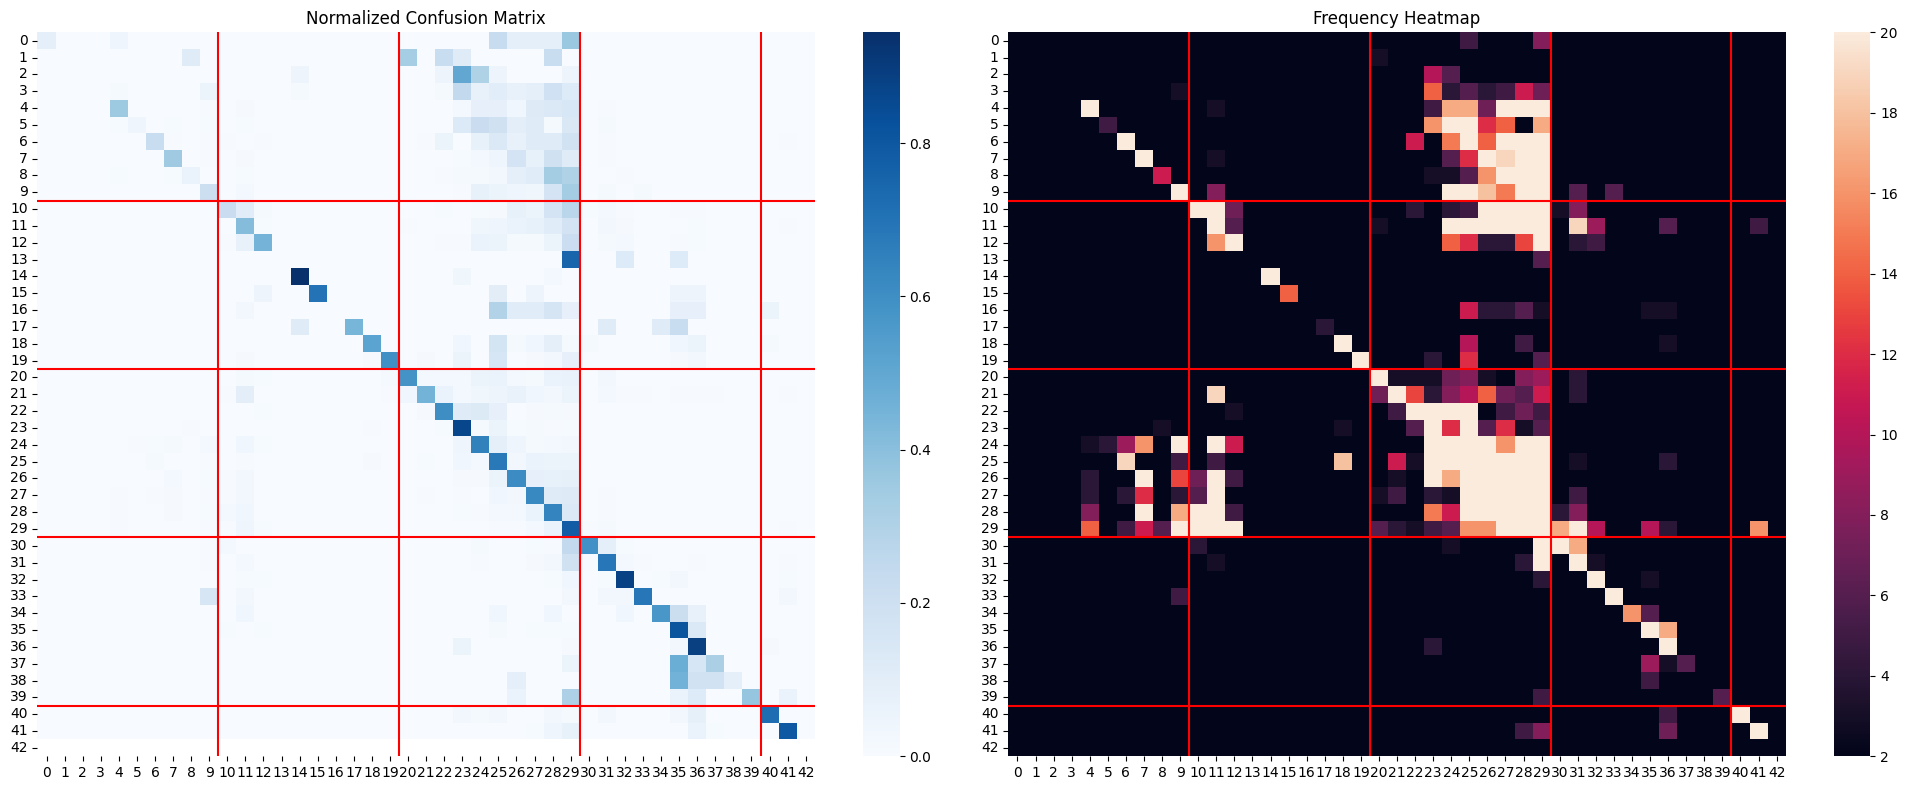

In [865]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

tick_positions = np.arange(43)

cm = confusion_matrix(test_true_longformer3_multiple, test_preds_argmax_longformer3_multiple, labels=np.arange(43))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, cmap='Blues', ax=ax1)

ax1.set_xticks(tick_positions + 0.5)
ax1.set_xticklabels(tick_positions)
ax1.set_title('Normalized Confusion Matrix')


freq3 = np.zeros((43,43))
for b, c in zip(test_true_longformer3_multiple, test_preds_argmax_longformer3_multiple):
    freq3[b,c] += 1
    
sns.heatmap(freq3, vmin=2, vmax=20, cmap='rocket', ax=ax2)

ax2.set_xticks(tick_positions + 0.5)
ax2.set_xticklabels(tick_positions)
ax2.set_title('Frequency Heatmap')

for dec_line in range(10,50,10):
    ax1.axvline(dec_line, color='red')
    ax1.axhline(dec_line, color='red')
    ax2.axvline(dec_line, color='red')
    ax2.axhline(dec_line, color='red')
    
plt.tight_layout()
plt.show()

In [878]:
print(f"Single:   argmax (MAE): {mean_avg_error(np.array(test_true_longformer3_single), np.array(test_preds_argmax_longformer3_single))}")
print(f"Multiple: argmax (MAE): {mean_avg_error(np.array(test_true_longformer3_multiple), np.array(test_preds_argmax_longformer3_multiple))}")
print(f"Multiple: new_argmax (MAE): {mean_avg_error(np.array(test_true_longformer3_multiple), np.array(test_new_preds_argmax_longformer3_multiple))}")


Single:   argmax (MAE): 0.16963418582065393
Multiple: argmax (MAE): 3.8561122244488977
Multiple: new_argmax (MAE): 12.534134936539747


### Longformer without cp (blacklist)

In [1057]:
X_valid_white = []
y_valid_white = []

X_valid_black = []
y_valid_black = []


for idx, row in valid.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    year = (century-1) * 10 + (decade-1)
    if idx in valid_blacklist:
        y_valid_black.append(year)
        X_valid_black.append(file_name)
    else:
        y_valid_white.append(year)
        X_valid_white.append(file_name)

#train_years_counter = Counter(y_train_22)
#valid_years_counter = Counter(y_valid_22)

In [1058]:
valid_white_dataset = TextDataset(X_valid_white, y_valid_white, valid_path)
valid_black_dataset = TextDataset(X_valid_black, y_valid_black, valid_path) # Full

batch_size = 16
valid_white_dataloader = DataLoader(valid_white_dataset, batch_size=batch_size, shuffle=False)
valid_black_dataloader = DataLoader(valid_black_dataset, batch_size=batch_size, shuffle=False)


In [1060]:
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/longformer-base-4096/decade_classifier_weights_3.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()
print()

In [1061]:
y_white_pred = []
y_white_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_white_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_white_pred.extend(predictions.detach().cpu().numpy())
        y_white_true.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [43:14<00:00,  1.17it/s]


In [1062]:
y_black_pred = []
y_black_true = []

with torch.no_grad():
    for text, labels in tqdm(valid_black_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_black_pred.extend(predictions.detach().cpu().numpy())
        y_black_true.extend(labels.cpu().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [05:48<00:00,  1.12it/s]


In [1065]:
print(mean_avg_error(np.array(y_white_true), np.array(y_white_pred)))
print(mean_avg_error(np.array(y_black_true), np.array(y_black_pred)))

0.8266322314049587
12.832826747720365


/tmp/ipykernel_559954/2446693000.py:7: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


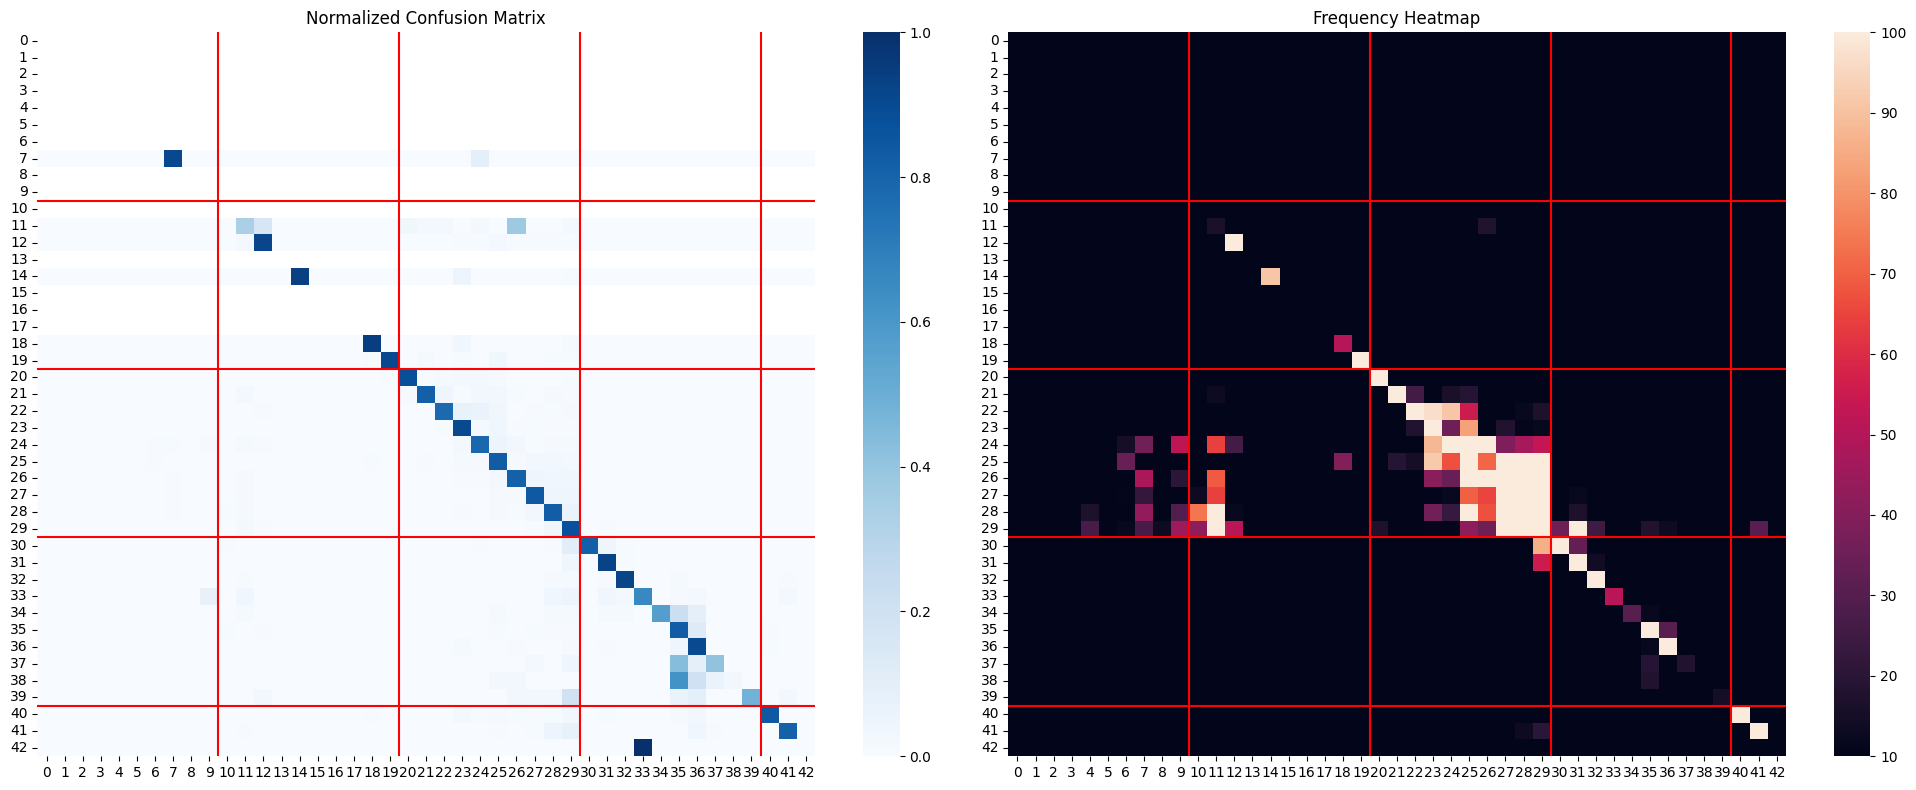

In [1086]:
plot_cm(y_white_true, y_white_pred, 10, 100)

/tmp/ipykernel_559954/2446693000.py:7: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


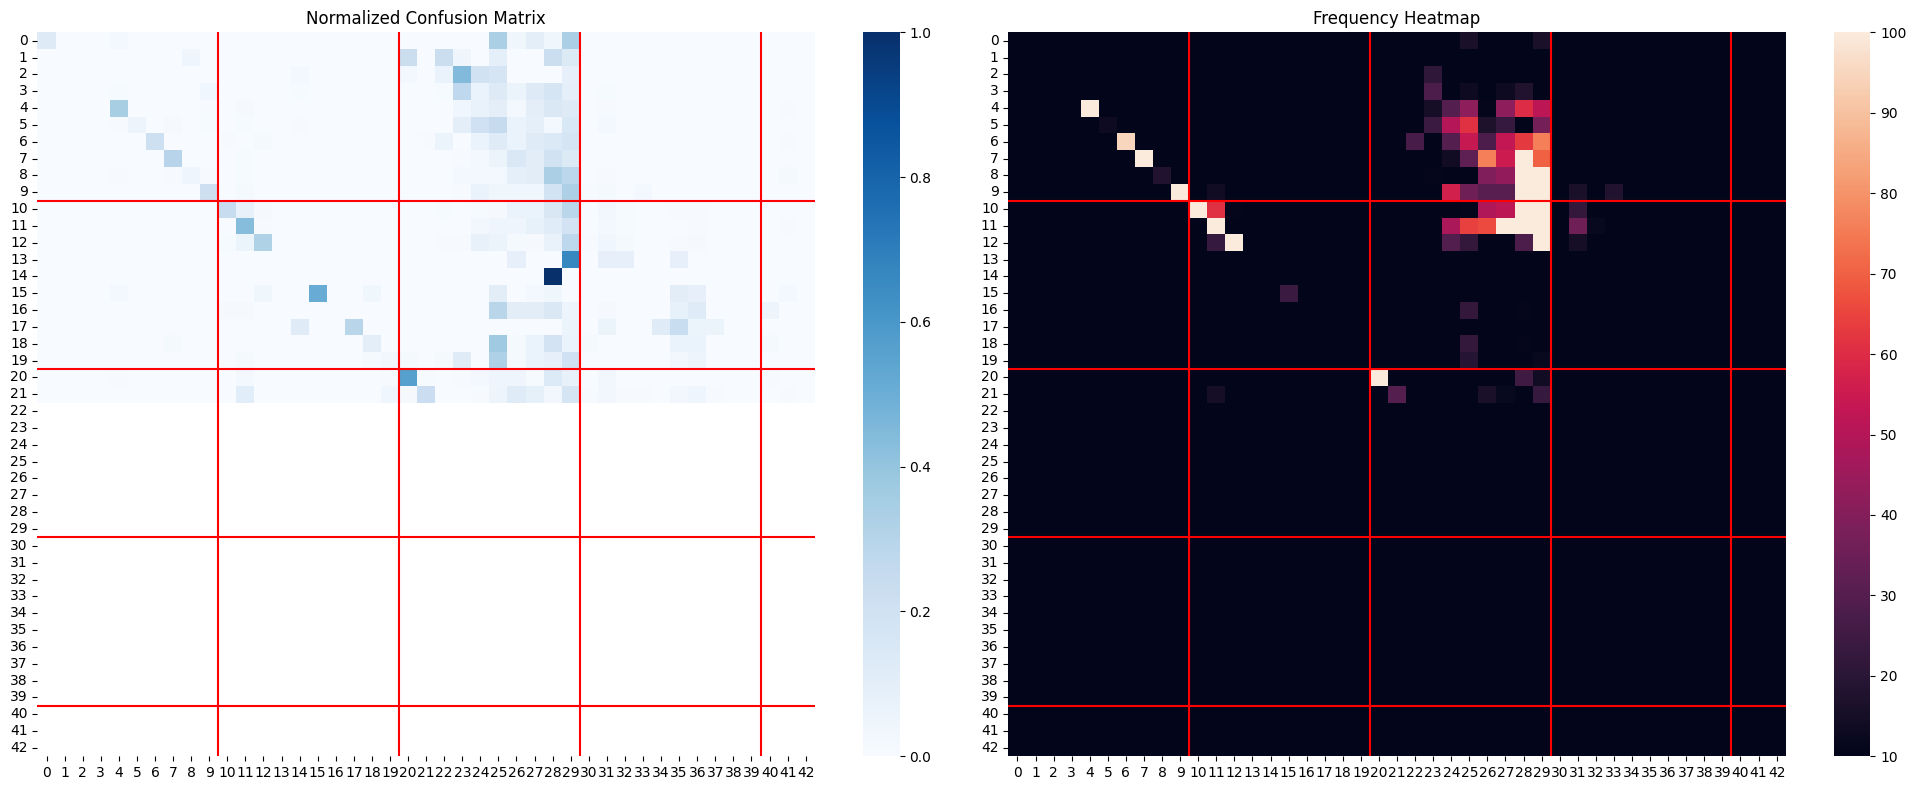

In [1087]:
plot_cm(y_black_true, y_black_pred, 10, 100)

### With conformal prediction

In [1073]:
from sklearn.model_selection import train_test_split
# Split validation data into calibration and test sets
X_calib_white, X_test_white, y_calib_white, y_test_white = train_test_split(
    X_valid_white, y_valid_white, test_size=0.5, random_state=RANDOM_SEED
)

# Create datasets and dataloaders
calib_white_dataset = TextDataset(X_calib_white, y_calib_white, valid_path)
test_white_dataset = TextDataset(X_test_white, y_test_white, valid_path)
calib_white_dataloader = DataLoader(calib_white_dataset, batch_size=16, shuffle=False)
test_white_dataloader = DataLoader(test_white_dataset, batch_size=16, shuffle=False)

In [1074]:
# Calibration
calib_probs_longformer_white = []
calib_preds_longformer_white = []
calib_true_longformer_white = []

with torch.no_grad():
    for text, labels in tqdm(calib_white_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)
        calib_probs_longformer_white.extend(probabilities.detach().cpu().numpy())
        calib_preds_longformer_white.extend(predictions.detach().cpu().numpy())
        calib_true_longformer_white.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [22:15<00:00,  1.13it/s]


In [1078]:
# Group calibration data by true class
class_nonconformity_longformer_white = {class_idx: [] for class_idx in range(43)}

# Compute class-specific nonconformity scores
for i, (prob, true_label) in enumerate(zip(calib_probs_longformer_white, calib_true_longformer_white)):
    nonconformity = 1 - prob[true_label]
    class_nonconformity_longformer_white[true_label].append(nonconformity)

# Calculate threshold for each class
class_thresholds_longformer_white = {}
confidence_level = 0.90
alpha = 1 - confidence_level

n_samples = len(calib_true_longformer_white)
for class_idx, scores in class_nonconformity_longformer_white.items():
    # class_thresholds_longformer2[class_idx] = np.quantile(scores, 1 - alpha)
    if len(scores) > 0:
        q = np.ceil((n_samples + 1) * (1 - alpha)) / n_samples # corrected formula
        class_thresholds_longformer_white[class_idx] = np.quantile(scores, q)
    else:
        class_thresholds_longformer_white[class_idx] = threshold
        

In [1080]:
test_preds_longformer_white = []
test_intervals_longformer_white = []
test_true_longformer_white = []
test_probs_longformer_white = []

with torch.no_grad():
    for text, labels in tqdm(test_white_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        for i, prob in enumerate(probabilities): # Iterate on the batch
            pred = predictions[i].item()
            true_label = labels[i].item()          
            # Create prediction set using class-specific thresholds
            prediction_set = []
            for label in range(43):
                # Use threshold specific to the candidate class
                if 1 - prob[label].item() <= class_thresholds_longformer_white[label]:
                    prediction_set.append(label)  
                    
            test_preds_longformer_white.append(pred)
            test_intervals_longformer_white.append(prediction_set)
            test_true_longformer_white.append(true_label)
            test_probs_longformer_white.append(prob.detach().cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1513/1513 [22:00<00:00,  1.15it/s]


In [1081]:
test_preds_argmax_longformer_white = []
test_preds_var_longformer_white = []
test_preds_var_rel_longformer_white = []

test_true_var_longformer_white = []
thslds_white = [ 1 - x for x in class_thresholds_longformer_white.values()]

for idx in range(len(test_probs_longformer_white)):
    intervals = test_intervals_longformer_white[idx]
    #if len(intervals) != 1:
    #    continue
    true_label = test_true_longformer_white[idx]
    probs = test_probs_longformer_white[idx]
    
    exeeding_idx = np.zeros(43)
    exeeding_rel_idx = np.zeros(43)
    
    for interval in intervals:
        if probs[interval] > thslds_white[interval]:
            
            exeeding_idx[interval] = abs(probs[interval]-thslds_white[interval])
            
            exeeding_rel_idx[interval] = abs(probs[interval]-thslds_white[interval]) / probs[interval]
            
    test_preds_argmax_longformer_white.append(np.argmax(probs))
    test_preds_var_longformer_white.append(np.argmax(exeeding_idx))
    test_preds_var_rel_longformer_white.append(np.argmax(exeeding_rel_idx))
    test_true_var_longformer_white.append(true_label)
    
print(f"argmax (MAE): {mean_avg_error(np.array(test_true_var_longformer_white), np.array(test_preds_argmax_longformer_white))}")
print(f"variance (MAE): {mean_avg_error(np.array(test_true_var_longformer_white), np.array(test_preds_var_longformer_white))}")
print(f"variance rel (MAE): {mean_avg_error(np.array(test_true_var_longformer_white), np.array(test_preds_var_rel_longformer_white))}")

argmax (MAE): 0.8136776859504132
variance (MAE): 0.8518181818181818
variance rel (MAE): 1.5017768595041323


### Longformer trained on coherent

In [1095]:
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

class BertForSequenceClassification(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)
    
model_decade_classifier = BertForSequenceClassification(model, 43)
model_decade_classifier.load_state_dict(torch.load('models/longformer-base-4096/decade_classifier_weights_3_coherent.pt'))
model_decade_classifier.to(device)

model_decade_classifier.eval()
print()

In [1096]:
y_pred_coh = []
y_true_coh = []
with torch.no_grad():
    for text, labels in tqdm(valid_22_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        predictions = output.argmax(dim=1)
        y_pred_coh.extend(predictions.detach().cpu().numpy())
        y_true_coh.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3416/3416 [28:03<00:00,  2.03it/s]


In [1097]:
print(f"argmax (MAE): {mean_avg_error(np.array(y_true_coh), np.array(y_pred_coh))}")

argmax (MAE): 2.3843113575231927


In [1104]:
y_pred_coh_white = []
y_true_coh_white = []

with torch.no_grad():
    for text, labels in tqdm(valid_white_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        y_pred_coh_white.extend(predictions.detach().cpu().numpy())
        y_true_coh_white.extend(labels.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3025/3025 [24:50<00:00,  2.03it/s]


In [1106]:
print(f"argmax (MAE): {mean_avg_error(np.array(y_true_coh_white), np.array(y_pred_coh_white))}")

argmax (MAE): 0.335599173553719


In [1101]:
y_pred_coh_black = []
y_true_coh_black = []

with torch.no_grad():
    for text, labels in tqdm(valid_black_dataloader):
        tokens = tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=512*3).to(device)
        output = model_decade_classifier(**tokens)
        probabilities = torch.softmax(output, dim=1)
        predictions = output.argmax(dim=1)      
        y_pred_coh_black.extend(predictions.detach().cpu().numpy())
        y_true_coh_black.extend(labels.cpu().numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:12<00:00,  2.04it/s]


In [1103]:
print(f"argmax (MAE): {mean_avg_error(np.array(y_true_coh_black), np.array(y_pred_coh_black))}")

argmax (MAE): 18.247000479923212


/tmp/ipykernel_559954/2446693000.py:7: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


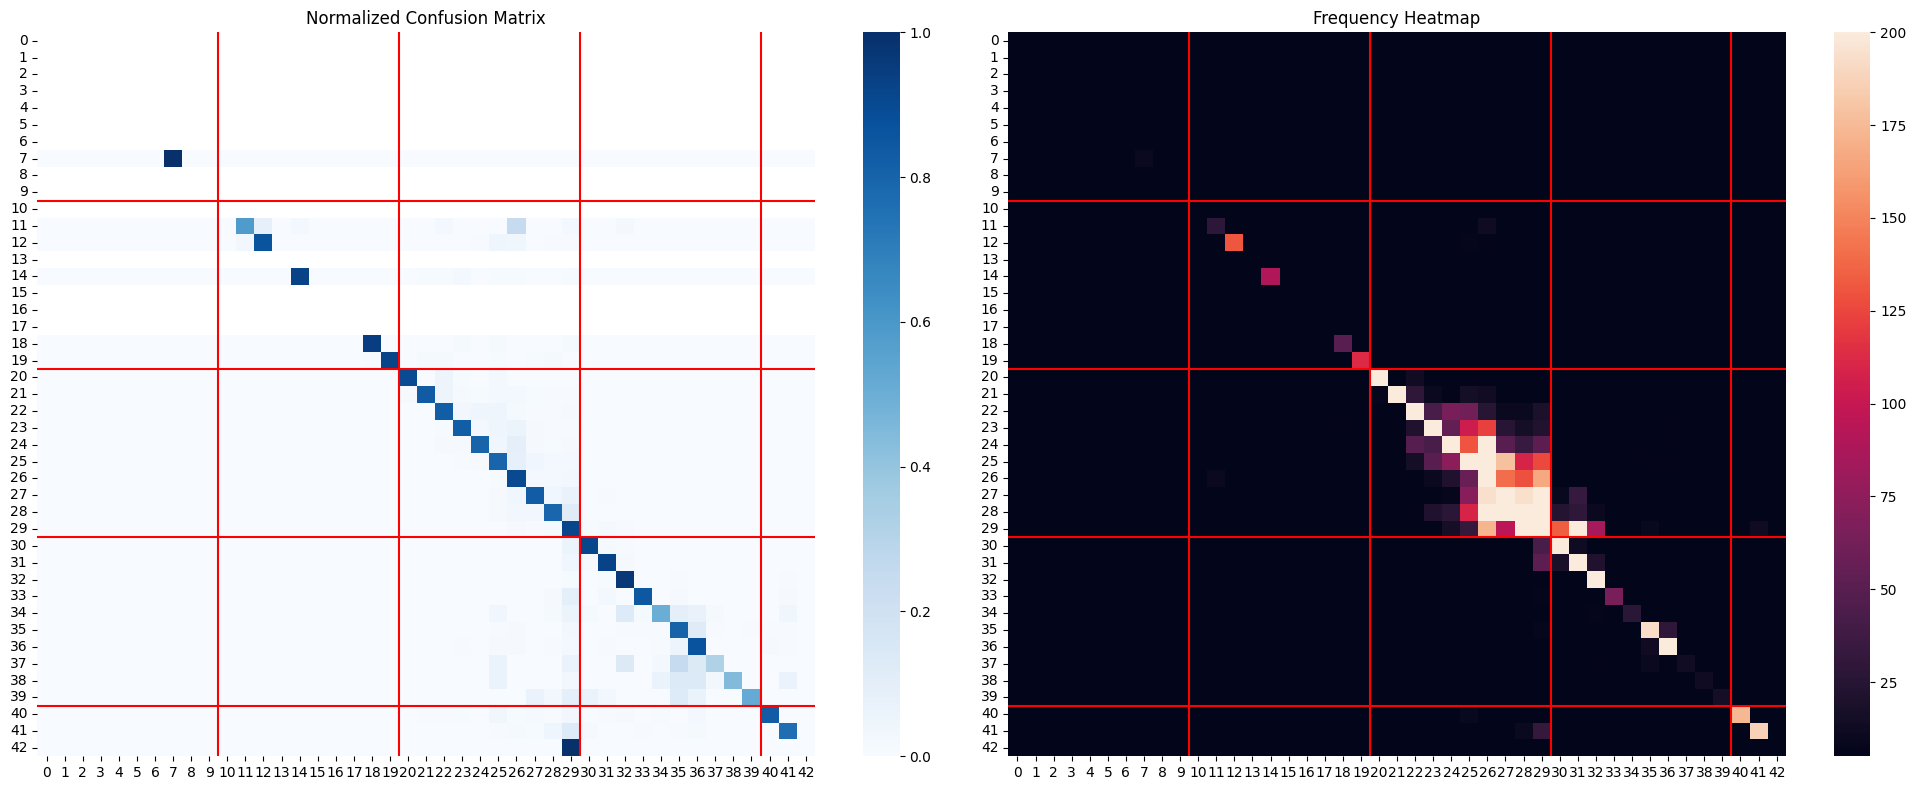

In [1112]:
plot_cm(y_true_coh_white, y_pred_coh_white, 5, 200)

/tmp/ipykernel_559954/2446693000.py:7: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


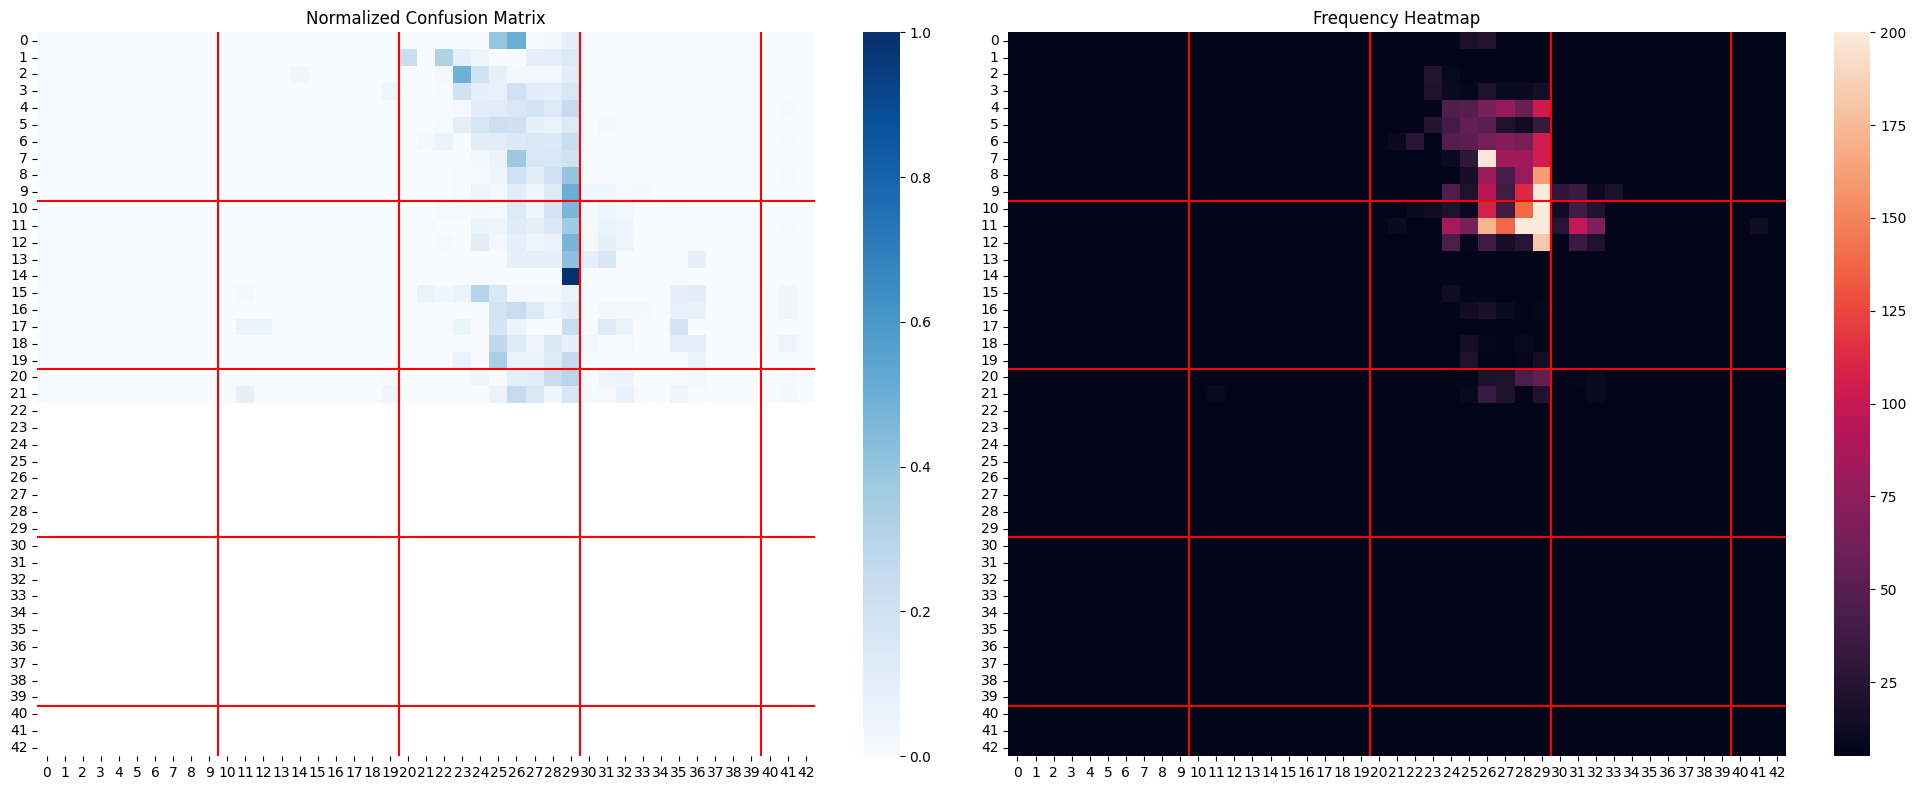

In [1113]:
plot_cm(y_true_coh_black, y_true_coh_black, 5, 200)

### Compare the datasets

In [1168]:
with open('blacklist.pkl', 'rb') as f:
    blacklist = pickle.load(f)
    
blacklist_train = blacklist['train']
blacklist_valid = blacklist['valid']

In [1159]:
def find_encoding_problems(text):
    encoding_issue_pattern = re.compile(r'[\xC2-\xF4][\x80-\xBF]{1,5}')
    return encoding_issue_pattern.findall(text)

In [1172]:
train_exp = {}
valid_exp = {}

for idx, row in train.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    
    #if idx in blacklist_train:
    #    continue
    # year = (century+16)*100 + (decade-1)*10
    year = (century-1) * 10 + (decade-1)
    train_exp[idx] = {'filename': file_name, 'year': year}

for idx, row in valid.iterrows():
    file_name = row.file_name
    century = row.century
    decade = row.decade
    
    #if idx in blacklist_valid:
    #    continue
    year = (century-1) * 10 + (decade-1)
    valid_exp[idx] = {'filename': file_name, 'year': year}

In [1238]:
train_exp_ee = {}
for entry in train_exp.values():
    file_name = entry['filename']
    with open(os.path.join(train_path, file_name), 'r') as file:
                text = file.read()
    matches = find_encoding_problems(text)
    for match in matches:
        if match not in train_exp_ee.keys():
            train_exp_ee[match] = 1
        else:
            train_exp_ee[match] += 1
            
valid_exp_ee = {}
for entry in valid_exp.values():
    file_name = entry['filename']
    with open(os.path.join(valid_path, file_name), 'r') as file:
                text = file.read()
    matches = find_encoding_problems(text)
    for match in matches:
        if match not in valid_exp_ee.keys():
            valid_exp_ee[match] = 1
        else:
            valid_exp_ee[match] += 1

ee_in_both = set(train_exp_ee.keys()) & set(valid_exp_ee.keys())
ee_in_both = sorted(ee_in_both, key=lambda x: train_exp_ee[x], reverse=True)

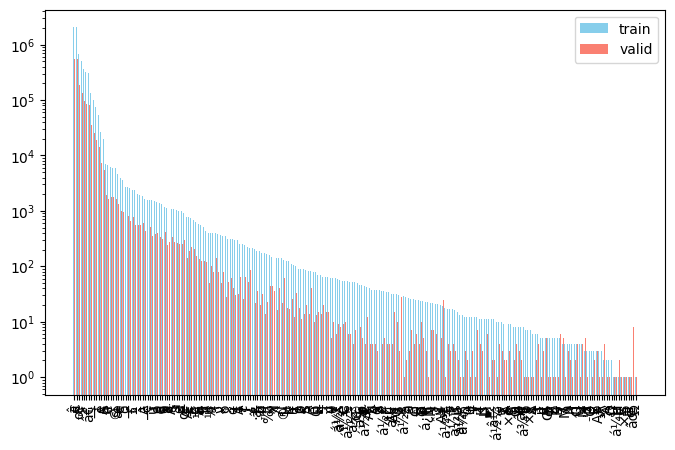

In [1236]:
data1 = { x: train_exp_ee[x] for x in ee_in_both}
data2 = { x: valid_exp_ee[x] for x in ee_in_both}

labels = [ ftfy.fix_text(x) for x in ee_in_both]
values1 = list(data1.values())
values2 = list(data2.values())

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, values1, width, label='train', color='skyblue')
plt.bar(x + width/2, values2, width, label='valid', color='salmon')

plt.xticks(x, labels, rotation=90)
plt.legend()
plt.yscale("log")

plt.show()